In [1]:
import pandas as pd
import logging
import numpy as np
from catboost import CatBoostClassifier, Pool, metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
import pickle

from src.utils import get_feat_names


In [2]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, roc_auc_score
from catboost import CatBoostClassifier, metrics

In [1]:
import os

os.chdir('../..')
print("Current working directory:", os.getcwd())

Current working directory: /dmj/fizmed/kchorzela/licencjat/eeg-site-effects


In [19]:
model_name = "catboost_v2"
save_path = f'results/pathology_classification/{model_name}/main_model/features_exclusion'
os.makedirs(save_path, exist_ok=True)

In [14]:
shap_values = np.load("results/hospital_classification/catboost_v2/main_model/mean_abs_shap_values.npy")
feature_names = np.array(get_feat_names())

In [6]:
comb_info_path = "datasets/combined/combined_info.csv"
comb_feats_path = "datasets/combined/combined_features.csv"

In [7]:
df_info = pd.read_csv(comb_info_path)
df_feats = pd.read_csv(comb_feats_path)

In [8]:
df_info.loc[:, 'cls_bin'] = np.where(df_info.loc[:, 'classification'] == 'patho', 1, 0)

In [9]:
X = df_feats
y = df_info['cls_bin']
groups = df_info['institution_id']

In [10]:
def get_scores(y_true, y_prob, th=0.5):
    y_pred = y_prob > th
    
    mcc = matthews_corrcoef(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_prob)
    
    return mcc, acc, precision, recall, f1, auc

In [11]:
from catboost import cv
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import shap

In [13]:
def get_all_features_to_remove(features):
    FREQ_BANDS = np.array(
        [
            [0.5, 2], [1, 3], [2, 4], [3, 6], [4, 8],
            [6, 10], [8, 13], [10, 15], [13, 18], [15, 21], [18, 24], [21, 27], [24, 30], [27, 40]
        ]
    )
    
    features_final = []
    for feat in features:
        if feat.startswith('cov_'):
            features_final.append(feat)
        elif feat.startswith('coh_'):
            base = "_".join(feat.split("_")[:3])
            for f_low, f_high in FREQ_BANDS:
                features_final.append(f"{base}_{int(float(f_low))}_{int(float(f_high))}")
        elif feat.startswith('pow_'):
            base = "_".join(feat.split("_")[:2])
            for f_low, f_high in FREQ_BANDS:
                features_final.append(f"{base}_{int(float(f_low))}_{int(float(f_high))}")
    return set(features_final)

In [18]:
params = {'iterations': 2000,
          'learning_rate': 0.2136106733298358,
          'depth': 5.0,
          'l2_leaf_reg': 1.0050061307458207,
          #'eval_metric': metrics.AUC(),
          'task_type': "GPU"
}
global_importance = np.abs(shap_values).sum(axis=1)  # shape: (n_features,)
sorted_idx = np.argsort(global_importance)[::-1]
features_to_exclude = np.array(feature_names)[sorted_idx]

percentages = [5, 10, 20, 50, 70, 90]
results = []
for pct in percentages[::-1]:
    num_features_to_remove = int(len(features_to_exclude) * pct / 100)
    features_to_remove = features_to_exclude[:num_features_to_remove]
    features_to_remove_final = get_all_features_to_remove(features_to_remove)
    df_feats_cur = df_feats.drop(columns=features_to_remove_final)
    
    X = df_feats_cur
    y = df_info['cls_bin']
    logo = LeaveOneGroupOut()
    for train_idx, test_idx in logo.split(X, y, groups):
        logging.info("Initializing the CatBoost model...")
        model = CatBoostClassifier(**params)
        
        hospital_test = df_info['institution_id'].iloc[test_idx].unique()[0]
        
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
        
        logging.info(f"Starting validation for hospital: {hospital_test}")
        
        logging.info("Training the model...")
        model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False, plot=True)
        logging.info("Model training completed.")
        
        logging.info("Generating predictions...")
        y_prob = model.predict_proba(X_test)[:, 1]
        logging.info("Predictions generated successfully.")
    
        mcc, acc, precision, recall, f1, auc = get_scores(y_test, y_prob)
        logging.info(f"Calculated metrics - ACC: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}, MCC: {mcc:.2f}")
        
        results.append({
            'Group': f"{pct}%-{len(features_to_remove_final)}",
            'Hospital': hospital_test,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'MCC': mcc
        })
        logging.info(f"Results saved for hospital: {hospital_test}")

2025-05-13 22:34:22,043 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:22,046 - INFO - Starting validation for hospital: AKS
2025-05-13 22:34:22,047 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:25,353 - INFO - Model training completed.
2025-05-13 22:34:25,354 - INFO - Generating predictions...
2025-05-13 22:34:25,355 - INFO - Predictions generated successfully.
2025-05-13 22:34:25,360 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.91, Recall: 0.76, F1: 0.83, AUC: 0.77, MCC: 0.35
2025-05-13 22:34:25,360 - INFO - Results saved for hospital: AKS
2025-05-13 22:34:25,361 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:25,364 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:34:25,364 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:29,072 - INFO - Model training completed.
2025-05-13 22:34:29,072 - INFO - Generating predictions...
2025-05-13 22:34:29,075 - INFO - Predictions generated successfully.
2025-05-13 22:34:29,081 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.43, Recall: 0.60, F1: 0.50, AUC: 0.71, MCC: 0.29
2025-05-13 22:34:29,081 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:34:29,082 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:29,085 - INFO - Starting validation for hospital: B2K
2025-05-13 22:34:29,085 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:32,759 - INFO - Model training completed.
2025-05-13 22:34:32,759 - INFO - Generating predictions...
2025-05-13 22:34:32,761 - INFO - Predictions generated successfully.
2025-05-13 22:34:32,773 - INFO - Calculated metrics - ACC: 0.80, Precision: 0.59, Recall: 0.50, F1: 0.54, AUC: 0.77, MCC: 0.42
2025-05-13 22:34:32,773 - INFO - Results saved for hospital: B2K
2025-05-13 22:34:32,774 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:32,781 - INFO - Starting validation for hospital: CHE
2025-05-13 22:34:32,781 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:36,775 - INFO - Model training completed.
2025-05-13 22:34:36,776 - INFO - Generating predictions...
2025-05-13 22:34:36,776 - INFO - Predictions generated successfully.
2025-05-13 22:34:36,781 - INFO - Calculated metrics - ACC: 0.40, Precision: 0.94, Recall: 0.33, F1: 0.49, AUC: 0.69, MCC: 0.14
2025-05-13 22:34:36,782 - INFO - Results saved for hospital: CHE
2025-05-13 22:34:36,782 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:36,785 - INFO - Starting validation for hospital: CMD
2025-05-13 22:34:36,785 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:40,420 - INFO - Model training completed.
2025-05-13 22:34:40,421 - INFO - Generating predictions...
2025-05-13 22:34:40,427 - INFO - Predictions generated successfully.
2025-05-13 22:34:40,432 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.59, Recall: 0.48, F1: 0.53, AUC: 0.76, MCC: 0.35
2025-05-13 22:34:40,432 - INFO - Results saved for hospital: CMD
2025-05-13 22:34:40,433 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:40,436 - INFO - Starting validation for hospital: GAK
2025-05-13 22:34:40,436 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:44,122 - INFO - Model training completed.
2025-05-13 22:34:44,122 - INFO - Generating predictions...
2025-05-13 22:34:44,123 - INFO - Predictions generated successfully.
2025-05-13 22:34:44,129 - INFO - Calculated metrics - ACC: 0.44, Precision: 0.95, Recall: 0.39, F1: 0.55, AUC: 0.62, MCC: 0.14
2025-05-13 22:34:44,129 - INFO - Results saved for hospital: GAK
2025-05-13 22:34:44,129 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:44,132 - INFO - Starting validation for hospital: KAL
2025-05-13 22:34:44,132 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:47,881 - INFO - Model training completed.
2025-05-13 22:34:47,882 - INFO - Generating predictions...
2025-05-13 22:34:47,883 - INFO - Predictions generated successfully.
2025-05-13 22:34:47,893 - INFO - Calculated metrics - ACC: 0.59, Precision: 0.41, Recall: 0.71, F1: 0.52, AUC: 0.69, MCC: 0.22
2025-05-13 22:34:47,893 - INFO - Results saved for hospital: KAL
2025-05-13 22:34:47,894 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:47,900 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:34:47,900 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:52,042 - INFO - Model training completed.
2025-05-13 22:34:52,043 - INFO - Generating predictions...
2025-05-13 22:34:52,044 - INFO - Predictions generated successfully.
2025-05-13 22:34:52,052 - INFO - Calculated metrics - ACC: 0.54, Precision: 0.32, Recall: 0.80, F1: 0.45, AUC: 0.68, MCC: 0.22
2025-05-13 22:34:52,052 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:34:52,053 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:52,055 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:34:52,055 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:55,773 - INFO - Model training completed.
2025-05-13 22:34:55,773 - INFO - Generating predictions...
2025-05-13 22:34:55,774 - INFO - Predictions generated successfully.
2025-05-13 22:34:55,779 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.75, Recall: 0.79, F1: 0.77, AUC: 0.83, MCC: 0.49
2025-05-13 22:34:55,779 - INFO - Results saved for hospital: KIEG
2025-05-13 22:34:55,780 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:55,783 - INFO - Starting validation for hospital: KLU
2025-05-13 22:34:55,783 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:34:59,468 - INFO - Model training completed.
2025-05-13 22:34:59,468 - INFO - Generating predictions...
2025-05-13 22:34:59,469 - INFO - Predictions generated successfully.
2025-05-13 22:34:59,474 - INFO - Calculated metrics - ACC: 0.60, Precision: 0.79, Recall: 0.38, F1: 0.51, AUC: 0.69, MCC: 0.28
2025-05-13 22:34:59,474 - INFO - Results saved for hospital: KLU
2025-05-13 22:34:59,475 - INFO - Initializing the CatBoost model...
2025-05-13 22:34:59,478 - INFO - Starting validation for hospital: KUD
2025-05-13 22:34:59,478 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:03,317 - INFO - Model training completed.
2025-05-13 22:35:03,318 - INFO - Generating predictions...
2025-05-13 22:35:03,327 - INFO - Predictions generated successfully.
2025-05-13 22:35:03,336 - INFO - Calculated metrics - ACC: 0.67, Precision: 0.65, Recall: 0.57, F1: 0.61, AUC: 0.74, MCC: 0.32
2025-05-13 22:35:03,336 - INFO - Results saved for hospital: KUD
2025-05-13 22:35:03,337 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:03,342 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:35:03,342 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:07,315 - INFO - Model training completed.
2025-05-13 22:35:07,316 - INFO - Generating predictions...
2025-05-13 22:35:07,319 - INFO - Predictions generated successfully.
2025-05-13 22:35:07,324 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.50, Recall: 0.79, F1: 0.62, AUC: 0.79, MCC: 0.41
2025-05-13 22:35:07,324 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:35:07,325 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:07,328 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:35:07,328 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:11,007 - INFO - Model training completed.
2025-05-13 22:35:11,007 - INFO - Generating predictions...
2025-05-13 22:35:11,010 - INFO - Predictions generated successfully.
2025-05-13 22:35:11,015 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.67, Recall: 0.69, F1: 0.68, AUC: 0.79, MCC: 0.41
2025-05-13 22:35:11,015 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:35:11,016 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:11,019 - INFO - Starting validation for hospital: MKW
2025-05-13 22:35:11,019 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:14,819 - INFO - Model training completed.
2025-05-13 22:35:14,820 - INFO - Generating predictions...
2025-05-13 22:35:14,821 - INFO - Predictions generated successfully.
2025-05-13 22:35:14,826 - INFO - Calculated metrics - ACC: 0.67, Precision: 0.68, Recall: 0.77, F1: 0.72, AUC: 0.75, MCC: 0.33
2025-05-13 22:35:14,826 - INFO - Results saved for hospital: MKW
2025-05-13 22:35:14,827 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:14,830 - INFO - Starting validation for hospital: MOR
2025-05-13 22:35:14,830 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:18,565 - INFO - Model training completed.
2025-05-13 22:35:18,566 - INFO - Generating predictions...
2025-05-13 22:35:18,567 - INFO - Predictions generated successfully.
2025-05-13 22:35:18,576 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.72, Recall: 0.88, F1: 0.79, AUC: 0.69, MCC: 0.27
2025-05-13 22:35:18,576 - INFO - Results saved for hospital: MOR
2025-05-13 22:35:18,578 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:18,583 - INFO - Starting validation for hospital: OST
2025-05-13 22:35:18,584 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:22,660 - INFO - Model training completed.
2025-05-13 22:35:22,661 - INFO - Generating predictions...
2025-05-13 22:35:22,662 - INFO - Predictions generated successfully.
2025-05-13 22:35:22,667 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.52, Recall: 0.86, F1: 0.64, AUC: 0.80, MCC: 0.36
2025-05-13 22:35:22,667 - INFO - Results saved for hospital: OST
2025-05-13 22:35:22,667 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:22,670 - INFO - Starting validation for hospital: OTW
2025-05-13 22:35:22,670 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:26,294 - INFO - Model training completed.
2025-05-13 22:35:26,294 - INFO - Generating predictions...
2025-05-13 22:35:26,297 - INFO - Predictions generated successfully.
2025-05-13 22:35:26,302 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.76, Recall: 0.55, F1: 0.64, AUC: 0.81, MCC: 0.48
2025-05-13 22:35:26,302 - INFO - Results saved for hospital: OTW
2025-05-13 22:35:26,303 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:26,305 - INFO - Starting validation for hospital: PIO
2025-05-13 22:35:26,306 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:29,954 - INFO - Model training completed.
2025-05-13 22:35:29,955 - INFO - Generating predictions...
2025-05-13 22:35:29,956 - INFO - Predictions generated successfully.
2025-05-13 22:35:29,963 - INFO - Calculated metrics - ACC: 0.36, Precision: 0.90, Recall: 0.35, F1: 0.51, AUC: 0.38, MCC: -0.08
2025-05-13 22:35:29,964 - INFO - Results saved for hospital: PIO
2025-05-13 22:35:29,964 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:29,967 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:35:29,967 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:33,823 - INFO - Model training completed.
2025-05-13 22:35:33,823 - INFO - Generating predictions...
2025-05-13 22:35:33,826 - INFO - Predictions generated successfully.
2025-05-13 22:35:33,836 - INFO - Calculated metrics - ACC: 0.67, Precision: 0.64, Recall: 0.59, F1: 0.62, AUC: 0.73, MCC: 0.33
2025-05-13 22:35:33,836 - INFO - Results saved for hospital: PRZ
2025-05-13 22:35:33,837 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:33,843 - INFO - Starting validation for hospital: PUS
2025-05-13 22:35:33,843 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:37,708 - INFO - Model training completed.
2025-05-13 22:35:37,708 - INFO - Generating predictions...
2025-05-13 22:35:37,709 - INFO - Predictions generated successfully.
2025-05-13 22:35:37,713 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.77, Recall: 0.74, F1: 0.75, AUC: 0.80, MCC: 0.44
2025-05-13 22:35:37,713 - INFO - Results saved for hospital: PUS
2025-05-13 22:35:37,714 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:37,717 - INFO - Starting validation for hospital: SL2
2025-05-13 22:35:37,717 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:41,459 - INFO - Model training completed.
2025-05-13 22:35:41,460 - INFO - Generating predictions...
2025-05-13 22:35:41,461 - INFO - Predictions generated successfully.
2025-05-13 22:35:41,465 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.72, Recall: 0.68, F1: 0.70, AUC: 0.76, MCC: 0.44
2025-05-13 22:35:41,466 - INFO - Results saved for hospital: SL2
2025-05-13 22:35:41,466 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:41,469 - INFO - Starting validation for hospital: SLU
2025-05-13 22:35:41,469 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:45,488 - INFO - Model training completed.
2025-05-13 22:35:45,488 - INFO - Generating predictions...
2025-05-13 22:35:45,491 - INFO - Predictions generated successfully.
2025-05-13 22:35:45,496 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.84, Recall: 0.81, F1: 0.82, AUC: 0.73, MCC: 0.24
2025-05-13 22:35:45,496 - INFO - Results saved for hospital: SLU
2025-05-13 22:35:45,497 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:45,500 - INFO - Starting validation for hospital: SRK
2025-05-13 22:35:45,500 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:49,423 - INFO - Model training completed.
2025-05-13 22:35:49,424 - INFO - Generating predictions...
2025-05-13 22:35:49,426 - INFO - Predictions generated successfully.
2025-05-13 22:35:49,436 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.66, Recall: 0.53, F1: 0.59, AUC: 0.77, MCC: 0.41
2025-05-13 22:35:49,436 - INFO - Results saved for hospital: SRK
2025-05-13 22:35:49,437 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:49,442 - INFO - Starting validation for hospital: STG1
2025-05-13 22:35:49,442 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:35:53,213 - INFO - Model training completed.
2025-05-13 22:35:53,213 - INFO - Generating predictions...
2025-05-13 22:35:53,214 - INFO - Predictions generated successfully.
2025-05-13 22:35:53,220 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.91, Recall: 0.44, F1: 0.59, AUC: 0.71, MCC: 0.24
2025-05-13 22:35:53,220 - INFO - Results saved for hospital: STG1
2025-05-13 22:35:53,221 - INFO - Initializing the CatBoost model...
2025-05-13 22:35:53,224 - INFO - Starting validation for hospital: SZC
2025-05-13 22:35:53,224 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:14,073 - INFO - Model training completed.
2025-05-13 22:36:14,074 - INFO - Generating predictions...
2025-05-13 22:36:14,078 - INFO - Predictions generated successfully.
2025-05-13 22:36:14,088 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.52, Recall: 0.82, F1: 0.64, AUC: 0.74, MCC: 0.31
2025-05-13 22:36:14,088 - INFO - Results saved for hospital: SZC
2025-05-13 22:36:14,089 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:14,092 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:36:14,092 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:17,890 - INFO - Model training completed.
2025-05-13 22:36:17,890 - INFO - Generating predictions...
2025-05-13 22:36:17,892 - INFO - Predictions generated successfully.
2025-05-13 22:36:17,901 - INFO - Calculated metrics - ACC: 0.55, Precision: 0.39, Recall: 0.59, F1: 0.47, AUC: 0.57, MCC: 0.12
2025-05-13 22:36:17,901 - INFO - Results saved for hospital: TER_L
2025-05-13 22:36:17,903 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:17,908 - INFO - Starting validation for hospital: TOR
2025-05-13 22:36:17,908 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:22,034 - INFO - Model training completed.
2025-05-13 22:36:22,034 - INFO - Generating predictions...
2025-05-13 22:36:22,035 - INFO - Predictions generated successfully.
2025-05-13 22:36:22,040 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.39, Recall: 0.84, F1: 0.54, AUC: 0.84, MCC: 0.40
2025-05-13 22:36:22,040 - INFO - Results saved for hospital: TOR
2025-05-13 22:36:22,041 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:22,044 - INFO - Starting validation for hospital: TUH
2025-05-13 22:36:22,044 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:26,322 - INFO - Model training completed.
2025-05-13 22:36:26,323 - INFO - Generating predictions...
2025-05-13 22:36:26,324 - INFO - Predictions generated successfully.
2025-05-13 22:36:26,329 - INFO - Calculated metrics - ACC: 0.66, Precision: 0.61, Recall: 0.85, F1: 0.71, AUC: 0.79, MCC: 0.34
2025-05-13 22:36:26,330 - INFO - Results saved for hospital: TUH
2025-05-13 22:36:26,330 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:26,333 - INFO - Starting validation for hospital: WLU
2025-05-13 22:36:26,333 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:29,994 - INFO - Model training completed.
2025-05-13 22:36:29,995 - INFO - Generating predictions...
2025-05-13 22:36:29,996 - INFO - Predictions generated successfully.
2025-05-13 22:36:30,002 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.84, Recall: 0.52, F1: 0.64, AUC: 0.63, MCC: 0.20
2025-05-13 22:36:30,002 - INFO - Results saved for hospital: WLU
2025-05-13 22:36:30,003 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:30,005 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:36:30,006 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:33,668 - INFO - Model training completed.
2025-05-13 22:36:33,669 - INFO - Generating predictions...
2025-05-13 22:36:33,669 - INFO - Predictions generated successfully.
2025-05-13 22:36:33,675 - INFO - Calculated metrics - ACC: 0.54, Precision: 0.87, Recall: 0.27, F1: 0.41, AUC: 0.68, MCC: 0.27
2025-05-13 22:36:33,676 - INFO - Results saved for hospital: Z04O
2025-05-13 22:36:33,676 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:33,679 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:36:33,679 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:37,360 - INFO - Model training completed.
2025-05-13 22:36:37,360 - INFO - Generating predictions...
2025-05-13 22:36:37,363 - INFO - Predictions generated successfully.
2025-05-13 22:36:37,368 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.83, Recall: 0.75, F1: 0.79, AUC: 0.84, MCC: 0.51
2025-05-13 22:36:37,368 - INFO - Results saved for hospital: ZOZLO
2025-05-13 22:36:37,399 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:37,404 - INFO - Starting validation for hospital: AKS
2025-05-13 22:36:37,404 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:41,220 - INFO - Model training completed.
2025-05-13 22:36:41,221 - INFO - Generating predictions...
2025-05-13 22:36:41,222 - INFO - Predictions generated successfully.
2025-05-13 22:36:41,227 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.92, Recall: 0.79, F1: 0.85, AUC: 0.80, MCC: 0.39
2025-05-13 22:36:41,227 - INFO - Results saved for hospital: AKS
2025-05-13 22:36:41,228 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:41,233 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:36:41,233 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:45,178 - INFO - Model training completed.
2025-05-13 22:36:45,179 - INFO - Generating predictions...
2025-05-13 22:36:45,181 - INFO - Predictions generated successfully.
2025-05-13 22:36:45,187 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.49, Recall: 0.53, F1: 0.51, AUC: 0.74, MCC: 0.33
2025-05-13 22:36:45,187 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:36:45,187 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:45,193 - INFO - Starting validation for hospital: B2K
2025-05-13 22:36:45,193 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:49,079 - INFO - Model training completed.
2025-05-13 22:36:49,079 - INFO - Generating predictions...
2025-05-13 22:36:49,082 - INFO - Predictions generated successfully.
2025-05-13 22:36:49,091 - INFO - Calculated metrics - ACC: 0.80, Precision: 0.61, Recall: 0.46, F1: 0.53, AUC: 0.76, MCC: 0.41
2025-05-13 22:36:49,092 - INFO - Results saved for hospital: B2K
2025-05-13 22:36:49,093 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:49,098 - INFO - Starting validation for hospital: CHE
2025-05-13 22:36:49,098 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:52,973 - INFO - Model training completed.
2025-05-13 22:36:52,974 - INFO - Generating predictions...
2025-05-13 22:36:52,975 - INFO - Predictions generated successfully.
2025-05-13 22:36:52,980 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.93, Recall: 0.50, F1: 0.65, AUC: 0.66, MCC: 0.17
2025-05-13 22:36:52,980 - INFO - Results saved for hospital: CHE
2025-05-13 22:36:52,981 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:52,986 - INFO - Starting validation for hospital: CMD
2025-05-13 22:36:52,986 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:36:56,908 - INFO - Model training completed.
2025-05-13 22:36:56,909 - INFO - Generating predictions...
2025-05-13 22:36:56,912 - INFO - Predictions generated successfully.
2025-05-13 22:36:56,917 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.70, Recall: 0.44, F1: 0.54, AUC: 0.79, MCC: 0.42
2025-05-13 22:36:56,917 - INFO - Results saved for hospital: CMD
2025-05-13 22:36:56,917 - INFO - Initializing the CatBoost model...
2025-05-13 22:36:56,923 - INFO - Starting validation for hospital: GAK
2025-05-13 22:36:56,923 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:00,779 - INFO - Model training completed.
2025-05-13 22:37:00,779 - INFO - Generating predictions...
2025-05-13 22:37:00,780 - INFO - Predictions generated successfully.
2025-05-13 22:37:00,785 - INFO - Calculated metrics - ACC: 0.47, Precision: 0.93, Recall: 0.43, F1: 0.59, AUC: 0.62, MCC: 0.11
2025-05-13 22:37:00,786 - INFO - Results saved for hospital: GAK
2025-05-13 22:37:00,786 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:00,792 - INFO - Starting validation for hospital: KAL
2025-05-13 22:37:00,792 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:04,783 - INFO - Model training completed.
2025-05-13 22:37:04,783 - INFO - Generating predictions...
2025-05-13 22:37:04,784 - INFO - Predictions generated successfully.
2025-05-13 22:37:04,788 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.39, Recall: 0.83, F1: 0.53, AUC: 0.72, MCC: 0.23
2025-05-13 22:37:04,789 - INFO - Results saved for hospital: KAL
2025-05-13 22:37:04,789 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:04,794 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:37:04,794 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:08,697 - INFO - Model training completed.
2025-05-13 22:37:08,697 - INFO - Generating predictions...
2025-05-13 22:37:08,699 - INFO - Predictions generated successfully.
2025-05-13 22:37:08,705 - INFO - Calculated metrics - ACC: 0.54, Precision: 0.31, Recall: 0.73, F1: 0.44, AUC: 0.68, MCC: 0.18
2025-05-13 22:37:08,705 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:37:08,705 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:08,710 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:37:08,710 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:12,595 - INFO - Model training completed.
2025-05-13 22:37:12,595 - INFO - Generating predictions...
2025-05-13 22:37:12,597 - INFO - Predictions generated successfully.
2025-05-13 22:37:12,601 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.78, Recall: 0.74, F1: 0.76, AUC: 0.82, MCC: 0.50
2025-05-13 22:37:12,601 - INFO - Results saved for hospital: KIEG
2025-05-13 22:37:12,602 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:12,607 - INFO - Starting validation for hospital: KLU
2025-05-13 22:37:12,607 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:16,615 - INFO - Model training completed.
2025-05-13 22:37:16,615 - INFO - Generating predictions...
2025-05-13 22:37:16,618 - INFO - Predictions generated successfully.
2025-05-13 22:37:16,623 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.75, Recall: 0.50, F1: 0.60, AUC: 0.69, MCC: 0.29
2025-05-13 22:37:16,623 - INFO - Results saved for hospital: KLU
2025-05-13 22:37:16,624 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:16,629 - INFO - Starting validation for hospital: KUD
2025-05-13 22:37:16,629 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:20,430 - INFO - Model training completed.
2025-05-13 22:37:20,431 - INFO - Generating predictions...
2025-05-13 22:37:20,432 - INFO - Predictions generated successfully.
2025-05-13 22:37:20,437 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.67, Recall: 0.57, F1: 0.62, AUC: 0.73, MCC: 0.35
2025-05-13 22:37:20,437 - INFO - Results saved for hospital: KUD
2025-05-13 22:37:20,437 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:20,442 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:37:20,442 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:24,330 - INFO - Model training completed.
2025-05-13 22:37:24,330 - INFO - Generating predictions...
2025-05-13 22:37:24,331 - INFO - Predictions generated successfully.
2025-05-13 22:37:24,336 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.49, Recall: 0.82, F1: 0.61, AUC: 0.79, MCC: 0.40
2025-05-13 22:37:24,336 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:37:24,337 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:24,342 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:37:24,342 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:28,296 - INFO - Model training completed.
2025-05-13 22:37:28,297 - INFO - Generating predictions...
2025-05-13 22:37:28,300 - INFO - Predictions generated successfully.
2025-05-13 22:37:28,308 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.69, Recall: 0.70, F1: 0.69, AUC: 0.79, MCC: 0.44
2025-05-13 22:37:28,308 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:37:28,308 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:28,313 - INFO - Starting validation for hospital: MKW
2025-05-13 22:37:28,314 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:32,202 - INFO - Model training completed.
2025-05-13 22:37:32,203 - INFO - Generating predictions...
2025-05-13 22:37:32,204 - INFO - Predictions generated successfully.
2025-05-13 22:37:32,209 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.70, Recall: 0.81, F1: 0.75, AUC: 0.76, MCC: 0.39
2025-05-13 22:37:32,209 - INFO - Results saved for hospital: MKW
2025-05-13 22:37:32,209 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:32,215 - INFO - Starting validation for hospital: MOR
2025-05-13 22:37:32,215 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:36,253 - INFO - Model training completed.
2025-05-13 22:37:36,254 - INFO - Generating predictions...
2025-05-13 22:37:36,255 - INFO - Predictions generated successfully.
2025-05-13 22:37:36,259 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.73, Recall: 0.82, F1: 0.77, AUC: 0.69, MCC: 0.26
2025-05-13 22:37:36,259 - INFO - Results saved for hospital: MOR
2025-05-13 22:37:36,260 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:36,265 - INFO - Starting validation for hospital: OST
2025-05-13 22:37:36,265 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:40,117 - INFO - Model training completed.
2025-05-13 22:37:40,117 - INFO - Generating predictions...
2025-05-13 22:37:40,120 - INFO - Predictions generated successfully.
2025-05-13 22:37:40,124 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.56, Recall: 0.85, F1: 0.67, AUC: 0.83, MCC: 0.42
2025-05-13 22:37:40,124 - INFO - Results saved for hospital: OST
2025-05-13 22:37:40,125 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:40,130 - INFO - Starting validation for hospital: OTW
2025-05-13 22:37:40,130 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:44,045 - INFO - Model training completed.
2025-05-13 22:37:44,045 - INFO - Generating predictions...
2025-05-13 22:37:44,046 - INFO - Predictions generated successfully.
2025-05-13 22:37:44,051 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.65, Recall: 0.67, F1: 0.66, AUC: 0.80, MCC: 0.44
2025-05-13 22:37:44,052 - INFO - Results saved for hospital: OTW
2025-05-13 22:37:44,052 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:44,057 - INFO - Starting validation for hospital: PIO
2025-05-13 22:37:44,057 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:48,025 - INFO - Model training completed.
2025-05-13 22:37:48,025 - INFO - Generating predictions...
2025-05-13 22:37:48,027 - INFO - Predictions generated successfully.
2025-05-13 22:37:48,032 - INFO - Calculated metrics - ACC: 0.42, Precision: 0.91, Recall: 0.41, F1: 0.56, AUC: 0.43, MCC: -0.05
2025-05-13 22:37:48,032 - INFO - Results saved for hospital: PIO
2025-05-13 22:37:48,033 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:48,038 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:37:48,039 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:52,024 - INFO - Model training completed.
2025-05-13 22:37:52,025 - INFO - Generating predictions...
2025-05-13 22:37:52,028 - INFO - Predictions generated successfully.
2025-05-13 22:37:52,033 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.62, Recall: 0.74, F1: 0.67, AUC: 0.74, MCC: 0.36
2025-05-13 22:37:52,033 - INFO - Results saved for hospital: PRZ
2025-05-13 22:37:52,033 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:52,038 - INFO - Starting validation for hospital: PUS
2025-05-13 22:37:52,039 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:55,859 - INFO - Model training completed.
2025-05-13 22:37:55,860 - INFO - Generating predictions...
2025-05-13 22:37:55,861 - INFO - Predictions generated successfully.
2025-05-13 22:37:55,866 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.75, Recall: 0.83, F1: 0.78, AUC: 0.81, MCC: 0.45
2025-05-13 22:37:55,866 - INFO - Results saved for hospital: PUS
2025-05-13 22:37:55,867 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:55,872 - INFO - Starting validation for hospital: SL2
2025-05-13 22:37:55,872 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:37:59,852 - INFO - Model training completed.
2025-05-13 22:37:59,853 - INFO - Generating predictions...
2025-05-13 22:37:59,854 - INFO - Predictions generated successfully.
2025-05-13 22:37:59,858 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.70, Recall: 0.64, F1: 0.67, AUC: 0.78, MCC: 0.40
2025-05-13 22:37:59,859 - INFO - Results saved for hospital: SL2
2025-05-13 22:37:59,859 - INFO - Initializing the CatBoost model...
2025-05-13 22:37:59,864 - INFO - Starting validation for hospital: SLU
2025-05-13 22:37:59,864 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:03,770 - INFO - Model training completed.
2025-05-13 22:38:03,770 - INFO - Generating predictions...
2025-05-13 22:38:03,772 - INFO - Predictions generated successfully.
2025-05-13 22:38:03,777 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.84, Recall: 0.83, F1: 0.84, AUC: 0.74, MCC: 0.26
2025-05-13 22:38:03,777 - INFO - Results saved for hospital: SLU
2025-05-13 22:38:03,778 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:03,783 - INFO - Starting validation for hospital: SRK
2025-05-13 22:38:03,783 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:07,753 - INFO - Model training completed.
2025-05-13 22:38:07,753 - INFO - Generating predictions...
2025-05-13 22:38:07,756 - INFO - Predictions generated successfully.
2025-05-13 22:38:07,760 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.70, Recall: 0.58, F1: 0.63, AUC: 0.80, MCC: 0.47
2025-05-13 22:38:07,761 - INFO - Results saved for hospital: SRK
2025-05-13 22:38:07,761 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:07,767 - INFO - Starting validation for hospital: STG1
2025-05-13 22:38:07,767 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:11,600 - INFO - Model training completed.
2025-05-13 22:38:11,600 - INFO - Generating predictions...
2025-05-13 22:38:11,601 - INFO - Predictions generated successfully.
2025-05-13 22:38:11,607 - INFO - Calculated metrics - ACC: 0.59, Precision: 0.87, Recall: 0.56, F1: 0.68, AUC: 0.69, MCC: 0.21
2025-05-13 22:38:11,608 - INFO - Results saved for hospital: STG1
2025-05-13 22:38:11,608 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:11,613 - INFO - Starting validation for hospital: SZC
2025-05-13 22:38:11,613 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:34,313 - INFO - Model training completed.
2025-05-13 22:38:34,314 - INFO - Generating predictions...
2025-05-13 22:38:34,317 - INFO - Predictions generated successfully.
2025-05-13 22:38:34,326 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.53, Recall: 0.79, F1: 0.63, AUC: 0.74, MCC: 0.31
2025-05-13 22:38:34,326 - INFO - Results saved for hospital: SZC
2025-05-13 22:38:34,327 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:34,332 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:38:34,332 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:38,317 - INFO - Model training completed.
2025-05-13 22:38:38,317 - INFO - Generating predictions...
2025-05-13 22:38:38,320 - INFO - Predictions generated successfully.
2025-05-13 22:38:38,324 - INFO - Calculated metrics - ACC: 0.61, Precision: 0.44, Recall: 0.62, F1: 0.52, AUC: 0.67, MCC: 0.22
2025-05-13 22:38:38,325 - INFO - Results saved for hospital: TER_L
2025-05-13 22:38:38,325 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:38,330 - INFO - Starting validation for hospital: TOR
2025-05-13 22:38:38,331 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:42,250 - INFO - Model training completed.
2025-05-13 22:38:42,251 - INFO - Generating predictions...
2025-05-13 22:38:42,252 - INFO - Predictions generated successfully.
2025-05-13 22:38:42,258 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.34, Recall: 0.86, F1: 0.49, AUC: 0.82, MCC: 0.34
2025-05-13 22:38:42,258 - INFO - Results saved for hospital: TOR
2025-05-13 22:38:42,259 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:42,264 - INFO - Starting validation for hospital: TUH
2025-05-13 22:38:42,264 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:46,176 - INFO - Model training completed.
2025-05-13 22:38:46,177 - INFO - Generating predictions...
2025-05-13 22:38:46,179 - INFO - Predictions generated successfully.
2025-05-13 22:38:46,184 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.67, Recall: 0.81, F1: 0.73, AUC: 0.81, MCC: 0.43
2025-05-13 22:38:46,184 - INFO - Results saved for hospital: TUH
2025-05-13 22:38:46,185 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:46,190 - INFO - Starting validation for hospital: WLU
2025-05-13 22:38:46,190 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:50,216 - INFO - Model training completed.
2025-05-13 22:38:50,217 - INFO - Generating predictions...
2025-05-13 22:38:50,218 - INFO - Predictions generated successfully.
2025-05-13 22:38:50,224 - INFO - Calculated metrics - ACC: 0.58, Precision: 0.81, Recall: 0.57, F1: 0.67, AUC: 0.63, MCC: 0.16
2025-05-13 22:38:50,225 - INFO - Results saved for hospital: WLU
2025-05-13 22:38:50,225 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:50,231 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:38:50,231 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:54,114 - INFO - Model training completed.
2025-05-13 22:38:54,115 - INFO - Generating predictions...
2025-05-13 22:38:54,116 - INFO - Predictions generated successfully.
2025-05-13 22:38:54,123 - INFO - Calculated metrics - ACC: 0.55, Precision: 0.82, Recall: 0.31, F1: 0.45, AUC: 0.63, MCC: 0.25
2025-05-13 22:38:54,123 - INFO - Results saved for hospital: Z04O
2025-05-13 22:38:54,124 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:54,129 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:38:54,130 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:38:58,042 - INFO - Model training completed.
2025-05-13 22:38:58,042 - INFO - Generating predictions...
2025-05-13 22:38:58,044 - INFO - Predictions generated successfully.
2025-05-13 22:38:58,049 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.83, Recall: 0.79, F1: 0.81, AUC: 0.86, MCC: 0.54
2025-05-13 22:38:58,049 - INFO - Results saved for hospital: ZOZLO
2025-05-13 22:38:58,075 - INFO - Initializing the CatBoost model...
2025-05-13 22:38:58,082 - INFO - Starting validation for hospital: AKS
2025-05-13 22:38:58,082 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:02,287 - INFO - Model training completed.
2025-05-13 22:39:02,287 - INFO - Generating predictions...
2025-05-13 22:39:02,288 - INFO - Predictions generated successfully.
2025-05-13 22:39:02,294 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.91, Recall: 0.79, F1: 0.85, AUC: 0.81, MCC: 0.38
2025-05-13 22:39:02,294 - INFO - Results saved for hospital: AKS
2025-05-13 22:39:02,294 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:02,302 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:39:02,302 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:06,509 - INFO - Model training completed.
2025-05-13 22:39:06,510 - INFO - Generating predictions...
2025-05-13 22:39:06,513 - INFO - Predictions generated successfully.
2025-05-13 22:39:06,521 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.50, Recall: 0.52, F1: 0.51, AUC: 0.74, MCC: 0.33
2025-05-13 22:39:06,521 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:39:06,521 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:06,529 - INFO - Starting validation for hospital: B2K
2025-05-13 22:39:06,529 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:10,793 - INFO - Model training completed.
2025-05-13 22:39:10,794 - INFO - Generating predictions...
2025-05-13 22:39:10,796 - INFO - Predictions generated successfully.
2025-05-13 22:39:10,801 - INFO - Calculated metrics - ACC: 0.82, Precision: 0.68, Recall: 0.45, F1: 0.54, AUC: 0.77, MCC: 0.45
2025-05-13 22:39:10,801 - INFO - Results saved for hospital: B2K
2025-05-13 22:39:10,802 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:10,809 - INFO - Starting validation for hospital: CHE
2025-05-13 22:39:10,809 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:14,996 - INFO - Model training completed.
2025-05-13 22:39:14,997 - INFO - Generating predictions...
2025-05-13 22:39:14,998 - INFO - Predictions generated successfully.
2025-05-13 22:39:15,003 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.96, Recall: 0.49, F1: 0.65, AUC: 0.70, MCC: 0.24
2025-05-13 22:39:15,003 - INFO - Results saved for hospital: CHE
2025-05-13 22:39:15,003 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:15,011 - INFO - Starting validation for hospital: CMD
2025-05-13 22:39:15,011 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:19,250 - INFO - Model training completed.
2025-05-13 22:39:19,250 - INFO - Generating predictions...
2025-05-13 22:39:19,252 - INFO - Predictions generated successfully.
2025-05-13 22:39:19,257 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.72, Recall: 0.43, F1: 0.54, AUC: 0.81, MCC: 0.42
2025-05-13 22:39:19,257 - INFO - Results saved for hospital: CMD
2025-05-13 22:39:19,257 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:19,265 - INFO - Starting validation for hospital: GAK
2025-05-13 22:39:19,265 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:23,507 - INFO - Model training completed.
2025-05-13 22:39:23,507 - INFO - Generating predictions...
2025-05-13 22:39:23,512 - INFO - Predictions generated successfully.
2025-05-13 22:39:23,517 - INFO - Calculated metrics - ACC: 0.60, Precision: 0.92, Recall: 0.60, F1: 0.73, AUC: 0.67, MCC: 0.13
2025-05-13 22:39:23,517 - INFO - Results saved for hospital: GAK
2025-05-13 22:39:23,518 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:23,525 - INFO - Starting validation for hospital: KAL
2025-05-13 22:39:23,525 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:27,691 - INFO - Model training completed.
2025-05-13 22:39:27,691 - INFO - Generating predictions...
2025-05-13 22:39:27,693 - INFO - Predictions generated successfully.
2025-05-13 22:39:27,698 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.39, Recall: 0.83, F1: 0.53, AUC: 0.69, MCC: 0.21
2025-05-13 22:39:27,698 - INFO - Results saved for hospital: KAL
2025-05-13 22:39:27,699 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:27,706 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:39:27,707 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:31,922 - INFO - Model training completed.
2025-05-13 22:39:31,923 - INFO - Generating predictions...
2025-05-13 22:39:31,925 - INFO - Predictions generated successfully.
2025-05-13 22:39:31,936 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.33, Recall: 0.74, F1: 0.46, AUC: 0.68, MCC: 0.22
2025-05-13 22:39:31,936 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:39:31,937 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:31,955 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:39:31,956 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:36,088 - INFO - Model training completed.
2025-05-13 22:39:36,088 - INFO - Generating predictions...
2025-05-13 22:39:36,090 - INFO - Predictions generated successfully.
2025-05-13 22:39:36,095 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.75, Recall: 0.78, F1: 0.77, AUC: 0.82, MCC: 0.49
2025-05-13 22:39:36,095 - INFO - Results saved for hospital: KIEG
2025-05-13 22:39:36,095 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:36,103 - INFO - Starting validation for hospital: KLU
2025-05-13 22:39:36,103 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:40,333 - INFO - Model training completed.
2025-05-13 22:39:40,333 - INFO - Generating predictions...
2025-05-13 22:39:40,336 - INFO - Predictions generated successfully.
2025-05-13 22:39:40,341 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.72, Recall: 0.57, F1: 0.63, AUC: 0.69, MCC: 0.28
2025-05-13 22:39:40,341 - INFO - Results saved for hospital: KLU
2025-05-13 22:39:40,342 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:40,349 - INFO - Starting validation for hospital: KUD
2025-05-13 22:39:40,349 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:44,682 - INFO - Model training completed.
2025-05-13 22:39:44,682 - INFO - Generating predictions...
2025-05-13 22:39:44,684 - INFO - Predictions generated successfully.
2025-05-13 22:39:44,688 - INFO - Calculated metrics - ACC: 0.67, Precision: 0.64, Recall: 0.60, F1: 0.62, AUC: 0.72, MCC: 0.33
2025-05-13 22:39:44,688 - INFO - Results saved for hospital: KUD
2025-05-13 22:39:44,689 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:44,696 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:39:44,696 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:48,799 - INFO - Model training completed.
2025-05-13 22:39:48,799 - INFO - Generating predictions...
2025-05-13 22:39:48,801 - INFO - Predictions generated successfully.
2025-05-13 22:39:48,806 - INFO - Calculated metrics - ACC: 0.65, Precision: 0.47, Recall: 0.83, F1: 0.60, AUC: 0.81, MCC: 0.38
2025-05-13 22:39:48,806 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:39:48,806 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:48,814 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:39:48,814 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:53,133 - INFO - Model training completed.
2025-05-13 22:39:53,133 - INFO - Generating predictions...
2025-05-13 22:39:53,135 - INFO - Predictions generated successfully.
2025-05-13 22:39:53,140 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.68, Recall: 0.66, F1: 0.67, AUC: 0.78, MCC: 0.41
2025-05-13 22:39:53,141 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:39:53,141 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:53,148 - INFO - Starting validation for hospital: MKW
2025-05-13 22:39:53,148 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:39:57,372 - INFO - Model training completed.
2025-05-13 22:39:57,372 - INFO - Generating predictions...
2025-05-13 22:39:57,374 - INFO - Predictions generated successfully.
2025-05-13 22:39:57,379 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.68, Recall: 0.83, F1: 0.75, AUC: 0.76, MCC: 0.37
2025-05-13 22:39:57,379 - INFO - Results saved for hospital: MKW
2025-05-13 22:39:57,379 - INFO - Initializing the CatBoost model...
2025-05-13 22:39:57,387 - INFO - Starting validation for hospital: MOR
2025-05-13 22:39:57,387 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:01,570 - INFO - Model training completed.
2025-05-13 22:40:01,571 - INFO - Generating predictions...
2025-05-13 22:40:01,572 - INFO - Predictions generated successfully.
2025-05-13 22:40:01,576 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.72, Recall: 0.91, F1: 0.80, AUC: 0.68, MCC: 0.28
2025-05-13 22:40:01,576 - INFO - Results saved for hospital: MOR
2025-05-13 22:40:01,577 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:01,584 - INFO - Starting validation for hospital: OST
2025-05-13 22:40:01,584 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:05,802 - INFO - Model training completed.
2025-05-13 22:40:05,802 - INFO - Generating predictions...
2025-05-13 22:40:05,806 - INFO - Predictions generated successfully.
2025-05-13 22:40:05,811 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.56, Recall: 0.86, F1: 0.68, AUC: 0.83, MCC: 0.43
2025-05-13 22:40:05,811 - INFO - Results saved for hospital: OST
2025-05-13 22:40:05,812 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:05,819 - INFO - Starting validation for hospital: OTW
2025-05-13 22:40:05,819 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:10,035 - INFO - Model training completed.
2025-05-13 22:40:10,035 - INFO - Generating predictions...
2025-05-13 22:40:10,037 - INFO - Predictions generated successfully.
2025-05-13 22:40:10,042 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.68, Recall: 0.63, F1: 0.66, AUC: 0.82, MCC: 0.46
2025-05-13 22:40:10,042 - INFO - Results saved for hospital: OTW
2025-05-13 22:40:10,043 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:10,050 - INFO - Starting validation for hospital: PIO
2025-05-13 22:40:10,050 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:14,261 - INFO - Model training completed.
2025-05-13 22:40:14,262 - INFO - Generating predictions...
2025-05-13 22:40:14,263 - INFO - Predictions generated successfully.
2025-05-13 22:40:14,271 - INFO - Calculated metrics - ACC: 0.41, Precision: 0.90, Recall: 0.40, F1: 0.56, AUC: 0.41, MCC: -0.07
2025-05-13 22:40:14,271 - INFO - Results saved for hospital: PIO
2025-05-13 22:40:14,272 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:14,279 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:40:14,279 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:18,570 - INFO - Model training completed.
2025-05-13 22:40:18,571 - INFO - Generating predictions...
2025-05-13 22:40:18,574 - INFO - Predictions generated successfully.
2025-05-13 22:40:18,581 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.64, Recall: 0.73, F1: 0.68, AUC: 0.75, MCC: 0.39
2025-05-13 22:40:18,581 - INFO - Results saved for hospital: PRZ
2025-05-13 22:40:18,582 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:18,589 - INFO - Starting validation for hospital: PUS
2025-05-13 22:40:18,590 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:23,005 - INFO - Model training completed.
2025-05-13 22:40:23,005 - INFO - Generating predictions...
2025-05-13 22:40:23,007 - INFO - Predictions generated successfully.
2025-05-13 22:40:23,011 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.76, Recall: 0.79, F1: 0.77, AUC: 0.82, MCC: 0.45
2025-05-13 22:40:23,011 - INFO - Results saved for hospital: PUS
2025-05-13 22:40:23,012 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:23,020 - INFO - Starting validation for hospital: SL2
2025-05-13 22:40:23,020 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:27,230 - INFO - Model training completed.
2025-05-13 22:40:27,231 - INFO - Generating predictions...
2025-05-13 22:40:27,232 - INFO - Predictions generated successfully.
2025-05-13 22:40:27,237 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.69, Recall: 0.70, F1: 0.70, AUC: 0.78, MCC: 0.42
2025-05-13 22:40:27,237 - INFO - Results saved for hospital: SL2
2025-05-13 22:40:27,237 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:27,245 - INFO - Starting validation for hospital: SLU
2025-05-13 22:40:27,245 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:31,458 - INFO - Model training completed.
2025-05-13 22:40:31,458 - INFO - Generating predictions...
2025-05-13 22:40:31,460 - INFO - Predictions generated successfully.
2025-05-13 22:40:31,466 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.84, Recall: 0.82, F1: 0.83, AUC: 0.73, MCC: 0.26
2025-05-13 22:40:31,466 - INFO - Results saved for hospital: SLU
2025-05-13 22:40:31,467 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:31,475 - INFO - Starting validation for hospital: SRK
2025-05-13 22:40:31,475 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:35,748 - INFO - Model training completed.
2025-05-13 22:40:35,748 - INFO - Generating predictions...
2025-05-13 22:40:35,752 - INFO - Predictions generated successfully.
2025-05-13 22:40:35,756 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.69, Recall: 0.56, F1: 0.62, AUC: 0.80, MCC: 0.45
2025-05-13 22:40:35,756 - INFO - Results saved for hospital: SRK
2025-05-13 22:40:35,757 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:35,764 - INFO - Starting validation for hospital: STG1
2025-05-13 22:40:35,765 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:40:39,938 - INFO - Model training completed.
2025-05-13 22:40:39,939 - INFO - Generating predictions...
2025-05-13 22:40:39,942 - INFO - Predictions generated successfully.
2025-05-13 22:40:39,948 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.90, Recall: 0.51, F1: 0.65, AUC: 0.70, MCC: 0.24
2025-05-13 22:40:39,948 - INFO - Results saved for hospital: STG1
2025-05-13 22:40:39,949 - INFO - Initializing the CatBoost model...
2025-05-13 22:40:39,956 - INFO - Starting validation for hospital: SZC
2025-05-13 22:40:39,957 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:04,507 - INFO - Model training completed.
2025-05-13 22:41:04,508 - INFO - Generating predictions...
2025-05-13 22:41:04,511 - INFO - Predictions generated successfully.
2025-05-13 22:41:04,520 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.53, Recall: 0.80, F1: 0.64, AUC: 0.74, MCC: 0.32
2025-05-13 22:41:04,520 - INFO - Results saved for hospital: SZC
2025-05-13 22:41:04,521 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:04,529 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:41:04,530 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:08,785 - INFO - Model training completed.
2025-05-13 22:41:08,785 - INFO - Generating predictions...
2025-05-13 22:41:08,790 - INFO - Predictions generated successfully.
2025-05-13 22:41:08,795 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.46, Recall: 0.65, F1: 0.54, AUC: 0.69, MCC: 0.25
2025-05-13 22:41:08,795 - INFO - Results saved for hospital: TER_L
2025-05-13 22:41:08,796 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:08,803 - INFO - Starting validation for hospital: TOR
2025-05-13 22:41:08,803 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:12,942 - INFO - Model training completed.
2025-05-13 22:41:12,942 - INFO - Generating predictions...
2025-05-13 22:41:12,944 - INFO - Predictions generated successfully.
2025-05-13 22:41:12,948 - INFO - Calculated metrics - ACC: 0.59, Precision: 0.33, Recall: 0.89, F1: 0.48, AUC: 0.81, MCC: 0.33
2025-05-13 22:41:12,949 - INFO - Results saved for hospital: TOR
2025-05-13 22:41:12,949 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:12,957 - INFO - Starting validation for hospital: TUH
2025-05-13 22:41:12,957 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:17,145 - INFO - Model training completed.
2025-05-13 22:41:17,146 - INFO - Generating predictions...
2025-05-13 22:41:17,148 - INFO - Predictions generated successfully.
2025-05-13 22:41:17,154 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.68, Recall: 0.81, F1: 0.74, AUC: 0.82, MCC: 0.45
2025-05-13 22:41:17,154 - INFO - Results saved for hospital: TUH
2025-05-13 22:41:17,155 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:17,162 - INFO - Starting validation for hospital: WLU
2025-05-13 22:41:17,162 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:21,526 - INFO - Model training completed.
2025-05-13 22:41:21,526 - INFO - Generating predictions...
2025-05-13 22:41:21,527 - INFO - Predictions generated successfully.
2025-05-13 22:41:21,533 - INFO - Calculated metrics - ACC: 0.59, Precision: 0.82, Recall: 0.58, F1: 0.68, AUC: 0.64, MCC: 0.18
2025-05-13 22:41:21,533 - INFO - Results saved for hospital: WLU
2025-05-13 22:41:21,534 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:21,541 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:41:21,541 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:25,714 - INFO - Model training completed.
2025-05-13 22:41:25,715 - INFO - Generating predictions...
2025-05-13 22:41:25,716 - INFO - Predictions generated successfully.
2025-05-13 22:41:25,722 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.81, Recall: 0.37, F1: 0.51, AUC: 0.65, MCC: 0.27
2025-05-13 22:41:25,722 - INFO - Results saved for hospital: Z04O
2025-05-13 22:41:25,723 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:25,730 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:41:25,730 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:29,925 - INFO - Model training completed.
2025-05-13 22:41:29,926 - INFO - Generating predictions...
2025-05-13 22:41:29,928 - INFO - Predictions generated successfully.
2025-05-13 22:41:29,933 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.82, Recall: 0.81, F1: 0.82, AUC: 0.86, MCC: 0.55
2025-05-13 22:41:29,933 - INFO - Results saved for hospital: ZOZLO
2025-05-13 22:41:29,975 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:30,021 - INFO - Starting validation for hospital: AKS
2025-05-13 22:41:30,021 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:36,932 - INFO - Model training completed.
2025-05-13 22:41:36,932 - INFO - Generating predictions...
2025-05-13 22:41:36,938 - INFO - Predictions generated successfully.
2025-05-13 22:41:36,942 - INFO - Calculated metrics - ACC: 0.79, Precision: 0.92, Recall: 0.81, F1: 0.86, AUC: 0.83, MCC: 0.42
2025-05-13 22:41:36,943 - INFO - Results saved for hospital: AKS
2025-05-13 22:41:36,943 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:36,990 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:41:36,991 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:43,839 - INFO - Model training completed.
2025-05-13 22:41:43,840 - INFO - Generating predictions...
2025-05-13 22:41:43,847 - INFO - Predictions generated successfully.
2025-05-13 22:41:43,853 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.56, Recall: 0.53, F1: 0.54, AUC: 0.78, MCC: 0.39
2025-05-13 22:41:43,853 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:41:43,854 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:43,901 - INFO - Starting validation for hospital: B2K
2025-05-13 22:41:43,901 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:50,845 - INFO - Model training completed.
2025-05-13 22:41:50,845 - INFO - Generating predictions...
2025-05-13 22:41:50,850 - INFO - Predictions generated successfully.
2025-05-13 22:41:50,856 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.52, Recall: 0.63, F1: 0.57, AUC: 0.80, MCC: 0.42
2025-05-13 22:41:50,856 - INFO - Results saved for hospital: B2K
2025-05-13 22:41:50,857 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:50,904 - INFO - Starting validation for hospital: CHE
2025-05-13 22:41:50,904 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:41:57,921 - INFO - Model training completed.
2025-05-13 22:41:57,921 - INFO - Generating predictions...
2025-05-13 22:41:57,925 - INFO - Predictions generated successfully.
2025-05-13 22:41:57,930 - INFO - Calculated metrics - ACC: 0.54, Precision: 0.95, Recall: 0.50, F1: 0.65, AUC: 0.74, MCC: 0.21
2025-05-13 22:41:57,930 - INFO - Results saved for hospital: CHE
2025-05-13 22:41:57,931 - INFO - Initializing the CatBoost model...
2025-05-13 22:41:57,978 - INFO - Starting validation for hospital: CMD
2025-05-13 22:41:57,979 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:04,856 - INFO - Model training completed.
2025-05-13 22:42:04,857 - INFO - Generating predictions...
2025-05-13 22:42:04,862 - INFO - Predictions generated successfully.
2025-05-13 22:42:04,866 - INFO - Calculated metrics - ACC: 0.80, Precision: 0.74, Recall: 0.55, F1: 0.63, AUC: 0.85, MCC: 0.51
2025-05-13 22:42:04,866 - INFO - Results saved for hospital: CMD
2025-05-13 22:42:04,867 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:04,915 - INFO - Starting validation for hospital: GAK
2025-05-13 22:42:04,915 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:11,814 - INFO - Model training completed.
2025-05-13 22:42:11,814 - INFO - Generating predictions...
2025-05-13 22:42:11,818 - INFO - Predictions generated successfully.
2025-05-13 22:42:11,824 - INFO - Calculated metrics - ACC: 0.52, Precision: 0.95, Recall: 0.48, F1: 0.64, AUC: 0.69, MCC: 0.18
2025-05-13 22:42:11,824 - INFO - Results saved for hospital: GAK
2025-05-13 22:42:11,825 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:11,872 - INFO - Starting validation for hospital: KAL
2025-05-13 22:42:11,873 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:18,792 - INFO - Model training completed.
2025-05-13 22:42:18,792 - INFO - Generating predictions...
2025-05-13 22:42:18,796 - INFO - Predictions generated successfully.
2025-05-13 22:42:18,801 - INFO - Calculated metrics - ACC: 0.64, Precision: 0.46, Recall: 0.78, F1: 0.58, AUC: 0.74, MCC: 0.33
2025-05-13 22:42:18,802 - INFO - Results saved for hospital: KAL
2025-05-13 22:42:18,802 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:18,850 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:42:18,851 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:25,845 - INFO - Model training completed.
2025-05-13 22:42:25,845 - INFO - Generating predictions...
2025-05-13 22:42:25,850 - INFO - Predictions generated successfully.
2025-05-13 22:42:25,856 - INFO - Calculated metrics - ACC: 0.54, Precision: 0.32, Recall: 0.83, F1: 0.47, AUC: 0.73, MCC: 0.25
2025-05-13 22:42:25,856 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:42:25,856 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:25,903 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:42:25,904 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:32,895 - INFO - Model training completed.
2025-05-13 22:42:32,896 - INFO - Generating predictions...
2025-05-13 22:42:32,900 - INFO - Predictions generated successfully.
2025-05-13 22:42:32,905 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.73, Recall: 0.78, F1: 0.75, AUC: 0.83, MCC: 0.45
2025-05-13 22:42:32,905 - INFO - Results saved for hospital: KIEG
2025-05-13 22:42:32,906 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:32,957 - INFO - Starting validation for hospital: KLU
2025-05-13 22:42:32,957 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:39,936 - INFO - Model training completed.
2025-05-13 22:42:39,937 - INFO - Generating predictions...
2025-05-13 22:42:39,943 - INFO - Predictions generated successfully.
2025-05-13 22:42:39,948 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.76, Recall: 0.62, F1: 0.68, AUC: 0.75, MCC: 0.37
2025-05-13 22:42:39,949 - INFO - Results saved for hospital: KLU
2025-05-13 22:42:39,949 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:39,997 - INFO - Starting validation for hospital: KUD
2025-05-13 22:42:39,998 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:46,897 - INFO - Model training completed.
2025-05-13 22:42:46,898 - INFO - Generating predictions...
2025-05-13 22:42:46,903 - INFO - Predictions generated successfully.
2025-05-13 22:42:46,908 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.74, Recall: 0.62, F1: 0.67, AUC: 0.80, MCC: 0.45
2025-05-13 22:42:46,908 - INFO - Results saved for hospital: KUD
2025-05-13 22:42:46,909 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:46,958 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:42:46,959 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:42:54,267 - INFO - Model training completed.
2025-05-13 22:42:54,268 - INFO - Generating predictions...
2025-05-13 22:42:54,273 - INFO - Predictions generated successfully.
2025-05-13 22:42:54,277 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.50, Recall: 0.84, F1: 0.63, AUC: 0.84, MCC: 0.43
2025-05-13 22:42:54,277 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:42:54,278 - INFO - Initializing the CatBoost model...
2025-05-13 22:42:54,326 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:42:54,326 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:01,138 - INFO - Model training completed.
2025-05-13 22:43:01,138 - INFO - Generating predictions...
2025-05-13 22:43:01,144 - INFO - Predictions generated successfully.
2025-05-13 22:43:01,149 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.74, Recall: 0.62, F1: 0.67, AUC: 0.80, MCC: 0.46
2025-05-13 22:43:01,149 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:43:01,150 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:01,197 - INFO - Starting validation for hospital: MKW
2025-05-13 22:43:01,198 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:08,282 - INFO - Model training completed.
2025-05-13 22:43:08,283 - INFO - Generating predictions...
2025-05-13 22:43:08,287 - INFO - Predictions generated successfully.
2025-05-13 22:43:08,292 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.71, Recall: 0.86, F1: 0.78, AUC: 0.82, MCC: 0.45
2025-05-13 22:43:08,292 - INFO - Results saved for hospital: MKW
2025-05-13 22:43:08,292 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:08,340 - INFO - Starting validation for hospital: MOR
2025-05-13 22:43:08,341 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:15,282 - INFO - Model training completed.
2025-05-13 22:43:15,282 - INFO - Generating predictions...
2025-05-13 22:43:15,294 - INFO - Predictions generated successfully.
2025-05-13 22:43:15,302 - INFO - Calculated metrics - ACC: 0.79, Precision: 0.84, Recall: 0.83, F1: 0.84, AUC: 0.82, MCC: 0.53
2025-05-13 22:43:15,302 - INFO - Results saved for hospital: MOR
2025-05-13 22:43:15,303 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:15,362 - INFO - Starting validation for hospital: OST
2025-05-13 22:43:15,362 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:22,391 - INFO - Model training completed.
2025-05-13 22:43:22,391 - INFO - Generating predictions...
2025-05-13 22:43:22,397 - INFO - Predictions generated successfully.
2025-05-13 22:43:22,401 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.61, Recall: 0.87, F1: 0.72, AUC: 0.87, MCC: 0.51
2025-05-13 22:43:22,401 - INFO - Results saved for hospital: OST
2025-05-13 22:43:22,402 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:22,449 - INFO - Starting validation for hospital: OTW
2025-05-13 22:43:22,450 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:29,364 - INFO - Model training completed.
2025-05-13 22:43:29,365 - INFO - Generating predictions...
2025-05-13 22:43:29,370 - INFO - Predictions generated successfully.
2025-05-13 22:43:29,375 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.68, Recall: 0.68, F1: 0.68, AUC: 0.83, MCC: 0.48
2025-05-13 22:43:29,375 - INFO - Results saved for hospital: OTW
2025-05-13 22:43:29,376 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:29,423 - INFO - Starting validation for hospital: PIO
2025-05-13 22:43:29,423 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:36,342 - INFO - Model training completed.
2025-05-13 22:43:36,343 - INFO - Generating predictions...
2025-05-13 22:43:36,347 - INFO - Predictions generated successfully.
2025-05-13 22:43:36,351 - INFO - Calculated metrics - ACC: 0.52, Precision: 0.91, Recall: 0.54, F1: 0.67, AUC: 0.42, MCC: -0.06
2025-05-13 22:43:36,352 - INFO - Results saved for hospital: PIO
2025-05-13 22:43:36,352 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:36,404 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:43:36,405 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:43,329 - INFO - Model training completed.
2025-05-13 22:43:43,329 - INFO - Generating predictions...
2025-05-13 22:43:43,334 - INFO - Predictions generated successfully.
2025-05-13 22:43:43,339 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.68, Recall: 0.74, F1: 0.71, AUC: 0.82, MCC: 0.46
2025-05-13 22:43:43,339 - INFO - Results saved for hospital: PRZ
2025-05-13 22:43:43,340 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:43,406 - INFO - Starting validation for hospital: PUS
2025-05-13 22:43:43,407 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:50,558 - INFO - Model training completed.
2025-05-13 22:43:50,558 - INFO - Generating predictions...
2025-05-13 22:43:50,563 - INFO - Predictions generated successfully.
2025-05-13 22:43:50,567 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.76, Recall: 0.83, F1: 0.79, AUC: 0.83, MCC: 0.49
2025-05-13 22:43:50,567 - INFO - Results saved for hospital: PUS
2025-05-13 22:43:50,568 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:50,639 - INFO - Starting validation for hospital: SL2
2025-05-13 22:43:50,639 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:43:57,558 - INFO - Model training completed.
2025-05-13 22:43:57,558 - INFO - Generating predictions...
2025-05-13 22:43:57,563 - INFO - Predictions generated successfully.
2025-05-13 22:43:57,567 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.67, Recall: 0.79, F1: 0.72, AUC: 0.82, MCC: 0.44
2025-05-13 22:43:57,567 - INFO - Results saved for hospital: SL2
2025-05-13 22:43:57,568 - INFO - Initializing the CatBoost model...
2025-05-13 22:43:57,619 - INFO - Starting validation for hospital: SLU
2025-05-13 22:43:57,620 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:44:04,522 - INFO - Model training completed.
2025-05-13 22:44:04,522 - INFO - Generating predictions...
2025-05-13 22:44:04,527 - INFO - Predictions generated successfully.
2025-05-13 22:44:04,533 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.87, Recall: 0.81, F1: 0.84, AUC: 0.77, MCC: 0.35
2025-05-13 22:44:04,533 - INFO - Results saved for hospital: SLU
2025-05-13 22:44:04,533 - INFO - Initializing the CatBoost model...
2025-05-13 22:44:04,592 - INFO - Starting validation for hospital: SRK
2025-05-13 22:44:04,592 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:44:11,490 - INFO - Model training completed.
2025-05-13 22:44:11,490 - INFO - Generating predictions...
2025-05-13 22:44:11,495 - INFO - Predictions generated successfully.
2025-05-13 22:44:11,499 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.73, Recall: 0.51, F1: 0.60, AUC: 0.82, MCC: 0.46
2025-05-13 22:44:11,500 - INFO - Results saved for hospital: SRK
2025-05-13 22:44:11,500 - INFO - Initializing the CatBoost model...
2025-05-13 22:44:11,552 - INFO - Starting validation for hospital: STG1
2025-05-13 22:44:11,552 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:44:18,421 - INFO - Model training completed.
2025-05-13 22:44:18,422 - INFO - Generating predictions...
2025-05-13 22:44:18,426 - INFO - Predictions generated successfully.
2025-05-13 22:44:18,432 - INFO - Calculated metrics - ACC: 0.61, Precision: 0.92, Recall: 0.56, F1: 0.69, AUC: 0.74, MCC: 0.30
2025-05-13 22:44:18,432 - INFO - Results saved for hospital: STG1
2025-05-13 22:44:18,432 - INFO - Initializing the CatBoost model...
2025-05-13 22:44:18,477 - INFO - Starting validation for hospital: SZC
2025-05-13 22:44:18,478 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:44:57,118 - INFO - Model training completed.
2025-05-13 22:44:57,119 - INFO - Generating predictions...
2025-05-13 22:44:57,124 - INFO - Predictions generated successfully.
2025-05-13 22:44:57,133 - INFO - Calculated metrics - ACC: 0.69, Precision: 0.59, Recall: 0.78, F1: 0.67, AUC: 0.78, MCC: 0.40
2025-05-13 22:44:57,133 - INFO - Results saved for hospital: SZC
2025-05-13 22:44:57,134 - INFO - Initializing the CatBoost model...
2025-05-13 22:44:57,212 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:44:57,213 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:04,082 - INFO - Model training completed.
2025-05-13 22:45:04,083 - INFO - Generating predictions...
2025-05-13 22:45:04,087 - INFO - Predictions generated successfully.
2025-05-13 22:45:04,092 - INFO - Calculated metrics - ACC: 0.58, Precision: 0.42, Recall: 0.66, F1: 0.52, AUC: 0.64, MCC: 0.19
2025-05-13 22:45:04,092 - INFO - Results saved for hospital: TER_L
2025-05-13 22:45:04,093 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:04,188 - INFO - Starting validation for hospital: TOR
2025-05-13 22:45:04,188 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:10,974 - INFO - Model training completed.
2025-05-13 22:45:10,974 - INFO - Generating predictions...
2025-05-13 22:45:10,978 - INFO - Predictions generated successfully.
2025-05-13 22:45:10,983 - INFO - Calculated metrics - ACC: 0.59, Precision: 0.34, Recall: 0.94, F1: 0.50, AUC: 0.81, MCC: 0.36
2025-05-13 22:45:10,983 - INFO - Results saved for hospital: TOR
2025-05-13 22:45:10,984 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:11,031 - INFO - Starting validation for hospital: TUH
2025-05-13 22:45:11,031 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:18,026 - INFO - Model training completed.
2025-05-13 22:45:18,027 - INFO - Generating predictions...
2025-05-13 22:45:18,036 - INFO - Predictions generated successfully.
2025-05-13 22:45:18,042 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.65, Recall: 0.86, F1: 0.74, AUC: 0.83, MCC: 0.44
2025-05-13 22:45:18,042 - INFO - Results saved for hospital: TUH
2025-05-13 22:45:18,042 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:18,088 - INFO - Starting validation for hospital: WLU
2025-05-13 22:45:18,088 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:25,029 - INFO - Model training completed.
2025-05-13 22:45:25,030 - INFO - Generating predictions...
2025-05-13 22:45:25,034 - INFO - Predictions generated successfully.
2025-05-13 22:45:25,040 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.86, Recall: 0.59, F1: 0.70, AUC: 0.69, MCC: 0.25
2025-05-13 22:45:25,040 - INFO - Results saved for hospital: WLU
2025-05-13 22:45:25,041 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:25,087 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:45:25,087 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:32,049 - INFO - Model training completed.
2025-05-13 22:45:32,050 - INFO - Generating predictions...
2025-05-13 22:45:32,054 - INFO - Predictions generated successfully.
2025-05-13 22:45:32,061 - INFO - Calculated metrics - ACC: 0.60, Precision: 0.81, Recall: 0.42, F1: 0.55, AUC: 0.71, MCC: 0.29
2025-05-13 22:45:32,061 - INFO - Results saved for hospital: Z04O
2025-05-13 22:45:32,062 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:32,111 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:45:32,111 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:38,907 - INFO - Model training completed.
2025-05-13 22:45:38,907 - INFO - Generating predictions...
2025-05-13 22:45:38,912 - INFO - Predictions generated successfully.
2025-05-13 22:45:38,917 - INFO - Calculated metrics - ACC: 0.80, Precision: 0.83, Recall: 0.84, F1: 0.84, AUC: 0.89, MCC: 0.59
2025-05-13 22:45:38,917 - INFO - Results saved for hospital: ZOZLO
2025-05-13 22:45:38,996 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:39,213 - INFO - Starting validation for hospital: AKS
2025-05-13 22:45:39,214 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:48,944 - INFO - Model training completed.
2025-05-13 22:45:48,944 - INFO - Generating predictions...
2025-05-13 22:45:48,952 - INFO - Predictions generated successfully.
2025-05-13 22:45:48,957 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.91, Recall: 0.81, F1: 0.86, AUC: 0.83, MCC: 0.38
2025-05-13 22:45:48,957 - INFO - Results saved for hospital: AKS
2025-05-13 22:45:48,957 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:49,105 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:45:49,106 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:45:58,647 - INFO - Model training completed.
2025-05-13 22:45:58,647 - INFO - Generating predictions...
2025-05-13 22:45:58,659 - INFO - Predictions generated successfully.
2025-05-13 22:45:58,665 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.57, Recall: 0.55, F1: 0.56, AUC: 0.78, MCC: 0.41
2025-05-13 22:45:58,665 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:45:58,665 - INFO - Initializing the CatBoost model...
2025-05-13 22:45:58,745 - INFO - Starting validation for hospital: B2K
2025-05-13 22:45:58,745 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:08,341 - INFO - Model training completed.
2025-05-13 22:46:08,341 - INFO - Generating predictions...
2025-05-13 22:46:08,349 - INFO - Predictions generated successfully.
2025-05-13 22:46:08,355 - INFO - Calculated metrics - ACC: 0.79, Precision: 0.55, Recall: 0.62, F1: 0.58, AUC: 0.80, MCC: 0.44
2025-05-13 22:46:08,355 - INFO - Results saved for hospital: B2K
2025-05-13 22:46:08,355 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:08,463 - INFO - Starting validation for hospital: CHE
2025-05-13 22:46:08,464 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:18,220 - INFO - Model training completed.
2025-05-13 22:46:18,220 - INFO - Generating predictions...
2025-05-13 22:46:18,228 - INFO - Predictions generated successfully.
2025-05-13 22:46:18,232 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.96, Recall: 0.48, F1: 0.64, AUC: 0.74, MCC: 0.22
2025-05-13 22:46:18,233 - INFO - Results saved for hospital: CHE
2025-05-13 22:46:18,233 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:18,330 - INFO - Starting validation for hospital: CMD
2025-05-13 22:46:18,330 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:27,912 - INFO - Model training completed.
2025-05-13 22:46:27,913 - INFO - Generating predictions...
2025-05-13 22:46:27,921 - INFO - Predictions generated successfully.
2025-05-13 22:46:27,925 - INFO - Calculated metrics - ACC: 0.79, Precision: 0.74, Recall: 0.50, F1: 0.60, AUC: 0.86, MCC: 0.48
2025-05-13 22:46:27,925 - INFO - Results saved for hospital: CMD
2025-05-13 22:46:27,926 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:28,008 - INFO - Starting validation for hospital: GAK
2025-05-13 22:46:28,008 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:37,581 - INFO - Model training completed.
2025-05-13 22:46:37,581 - INFO - Generating predictions...
2025-05-13 22:46:37,588 - INFO - Predictions generated successfully.
2025-05-13 22:46:37,592 - INFO - Calculated metrics - ACC: 0.55, Precision: 0.94, Recall: 0.53, F1: 0.68, AUC: 0.68, MCC: 0.17
2025-05-13 22:46:37,593 - INFO - Results saved for hospital: GAK
2025-05-13 22:46:37,593 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:37,675 - INFO - Starting validation for hospital: KAL
2025-05-13 22:46:37,675 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:47,272 - INFO - Model training completed.
2025-05-13 22:46:47,272 - INFO - Generating predictions...
2025-05-13 22:46:47,292 - INFO - Predictions generated successfully.
2025-05-13 22:46:47,300 - INFO - Calculated metrics - ACC: 0.64, Precision: 0.46, Recall: 0.73, F1: 0.57, AUC: 0.71, MCC: 0.31
2025-05-13 22:46:47,301 - INFO - Results saved for hospital: KAL
2025-05-13 22:46:47,302 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:47,398 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:46:47,398 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:46:57,442 - INFO - Model training completed.
2025-05-13 22:46:57,442 - INFO - Generating predictions...
2025-05-13 22:46:57,448 - INFO - Predictions generated successfully.
2025-05-13 22:46:57,454 - INFO - Calculated metrics - ACC: 0.53, Precision: 0.32, Recall: 0.87, F1: 0.47, AUC: 0.75, MCC: 0.26
2025-05-13 22:46:57,454 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:46:57,454 - INFO - Initializing the CatBoost model...
2025-05-13 22:46:57,535 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:46:57,535 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:07,174 - INFO - Model training completed.
2025-05-13 22:47:07,175 - INFO - Generating predictions...
2025-05-13 22:47:07,181 - INFO - Predictions generated successfully.
2025-05-13 22:47:07,186 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.75, Recall: 0.78, F1: 0.77, AUC: 0.83, MCC: 0.49
2025-05-13 22:47:07,186 - INFO - Results saved for hospital: KIEG
2025-05-13 22:47:07,187 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:07,268 - INFO - Starting validation for hospital: KLU
2025-05-13 22:47:07,269 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:16,793 - INFO - Model training completed.
2025-05-13 22:47:16,794 - INFO - Generating predictions...
2025-05-13 22:47:16,801 - INFO - Predictions generated successfully.
2025-05-13 22:47:16,806 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.76, Recall: 0.62, F1: 0.69, AUC: 0.74, MCC: 0.37
2025-05-13 22:47:16,807 - INFO - Results saved for hospital: KLU
2025-05-13 22:47:16,807 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:16,891 - INFO - Starting validation for hospital: KUD
2025-05-13 22:47:16,892 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:26,974 - INFO - Model training completed.
2025-05-13 22:47:26,974 - INFO - Generating predictions...
2025-05-13 22:47:26,982 - INFO - Predictions generated successfully.
2025-05-13 22:47:26,986 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.74, Recall: 0.62, F1: 0.68, AUC: 0.79, MCC: 0.46
2025-05-13 22:47:26,986 - INFO - Results saved for hospital: KUD
2025-05-13 22:47:26,987 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:27,070 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:47:27,071 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:36,649 - INFO - Model training completed.
2025-05-13 22:47:36,649 - INFO - Generating predictions...
2025-05-13 22:47:36,657 - INFO - Predictions generated successfully.
2025-05-13 22:47:36,662 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.55, Recall: 0.91, F1: 0.68, AUC: 0.87, MCC: 0.53
2025-05-13 22:47:36,662 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:47:36,663 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:36,745 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:47:36,745 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:46,326 - INFO - Model training completed.
2025-05-13 22:47:46,326 - INFO - Generating predictions...
2025-05-13 22:47:46,335 - INFO - Predictions generated successfully.
2025-05-13 22:47:46,340 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.74, Recall: 0.62, F1: 0.67, AUC: 0.81, MCC: 0.45
2025-05-13 22:47:46,340 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:47:46,341 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:46,423 - INFO - Starting validation for hospital: MKW
2025-05-13 22:47:46,423 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:47:56,508 - INFO - Model training completed.
2025-05-13 22:47:56,508 - INFO - Generating predictions...
2025-05-13 22:47:56,516 - INFO - Predictions generated successfully.
2025-05-13 22:47:56,520 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.70, Recall: 0.86, F1: 0.77, AUC: 0.82, MCC: 0.42
2025-05-13 22:47:56,520 - INFO - Results saved for hospital: MKW
2025-05-13 22:47:56,521 - INFO - Initializing the CatBoost model...
2025-05-13 22:47:56,603 - INFO - Starting validation for hospital: MOR
2025-05-13 22:47:56,603 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:06,198 - INFO - Model training completed.
2025-05-13 22:48:06,198 - INFO - Generating predictions...
2025-05-13 22:48:06,205 - INFO - Predictions generated successfully.
2025-05-13 22:48:06,209 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.79, Recall: 0.84, F1: 0.82, AUC: 0.79, MCC: 0.43
2025-05-13 22:48:06,209 - INFO - Results saved for hospital: MOR
2025-05-13 22:48:06,210 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:06,292 - INFO - Starting validation for hospital: OST
2025-05-13 22:48:06,293 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:15,991 - INFO - Model training completed.
2025-05-13 22:48:15,991 - INFO - Generating predictions...
2025-05-13 22:48:15,999 - INFO - Predictions generated successfully.
2025-05-13 22:48:16,004 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.62, Recall: 0.84, F1: 0.71, AUC: 0.86, MCC: 0.50
2025-05-13 22:48:16,004 - INFO - Results saved for hospital: OST
2025-05-13 22:48:16,004 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:16,086 - INFO - Starting validation for hospital: OTW
2025-05-13 22:48:16,086 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:25,775 - INFO - Model training completed.
2025-05-13 22:48:25,775 - INFO - Generating predictions...
2025-05-13 22:48:25,782 - INFO - Predictions generated successfully.
2025-05-13 22:48:25,787 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.74, Recall: 0.68, F1: 0.71, AUC: 0.84, MCC: 0.54
2025-05-13 22:48:25,787 - INFO - Results saved for hospital: OTW
2025-05-13 22:48:25,788 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:25,869 - INFO - Starting validation for hospital: PIO
2025-05-13 22:48:25,869 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:35,485 - INFO - Model training completed.
2025-05-13 22:48:35,485 - INFO - Generating predictions...
2025-05-13 22:48:35,492 - INFO - Predictions generated successfully.
2025-05-13 22:48:35,496 - INFO - Calculated metrics - ACC: 0.55, Precision: 0.91, Recall: 0.56, F1: 0.70, AUC: 0.45, MCC: -0.06
2025-05-13 22:48:35,496 - INFO - Results saved for hospital: PIO
2025-05-13 22:48:35,497 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:35,579 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:48:35,579 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:45,347 - INFO - Model training completed.
2025-05-13 22:48:45,347 - INFO - Generating predictions...
2025-05-13 22:48:45,355 - INFO - Predictions generated successfully.
2025-05-13 22:48:45,359 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.71, Recall: 0.75, F1: 0.73, AUC: 0.82, MCC: 0.50
2025-05-13 22:48:45,360 - INFO - Results saved for hospital: PRZ
2025-05-13 22:48:45,360 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:45,441 - INFO - Starting validation for hospital: PUS
2025-05-13 22:48:45,441 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:48:55,095 - INFO - Model training completed.
2025-05-13 22:48:55,095 - INFO - Generating predictions...
2025-05-13 22:48:55,103 - INFO - Predictions generated successfully.
2025-05-13 22:48:55,107 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.73, Recall: 0.83, F1: 0.78, AUC: 0.83, MCC: 0.44
2025-05-13 22:48:55,108 - INFO - Results saved for hospital: PUS
2025-05-13 22:48:55,108 - INFO - Initializing the CatBoost model...
2025-05-13 22:48:55,190 - INFO - Starting validation for hospital: SL2
2025-05-13 22:48:55,190 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:49:04,795 - INFO - Model training completed.
2025-05-13 22:49:04,795 - INFO - Generating predictions...
2025-05-13 22:49:04,803 - INFO - Predictions generated successfully.
2025-05-13 22:49:04,807 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.68, Recall: 0.76, F1: 0.72, AUC: 0.82, MCC: 0.44
2025-05-13 22:49:04,807 - INFO - Results saved for hospital: SL2
2025-05-13 22:49:04,808 - INFO - Initializing the CatBoost model...
2025-05-13 22:49:04,888 - INFO - Starting validation for hospital: SLU
2025-05-13 22:49:04,889 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:49:14,926 - INFO - Model training completed.
2025-05-13 22:49:14,926 - INFO - Generating predictions...
2025-05-13 22:49:14,934 - INFO - Predictions generated successfully.
2025-05-13 22:49:14,939 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.86, Recall: 0.85, F1: 0.85, AUC: 0.78, MCC: 0.34
2025-05-13 22:49:14,939 - INFO - Results saved for hospital: SLU
2025-05-13 22:49:14,940 - INFO - Initializing the CatBoost model...
2025-05-13 22:49:15,025 - INFO - Starting validation for hospital: SRK
2025-05-13 22:49:15,026 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:49:24,678 - INFO - Model training completed.
2025-05-13 22:49:24,678 - INFO - Generating predictions...
2025-05-13 22:49:24,686 - INFO - Predictions generated successfully.
2025-05-13 22:49:24,690 - INFO - Calculated metrics - ACC: 0.76, Precision: 0.71, Recall: 0.51, F1: 0.60, AUC: 0.83, MCC: 0.44
2025-05-13 22:49:24,690 - INFO - Results saved for hospital: SRK
2025-05-13 22:49:24,691 - INFO - Initializing the CatBoost model...
2025-05-13 22:49:24,772 - INFO - Starting validation for hospital: STG1
2025-05-13 22:49:24,772 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:49:34,365 - INFO - Model training completed.
2025-05-13 22:49:34,366 - INFO - Generating predictions...
2025-05-13 22:49:34,374 - INFO - Predictions generated successfully.
2025-05-13 22:49:34,380 - INFO - Calculated metrics - ACC: 0.63, Precision: 0.92, Recall: 0.58, F1: 0.71, AUC: 0.76, MCC: 0.32
2025-05-13 22:49:34,380 - INFO - Results saved for hospital: STG1
2025-05-13 22:49:34,381 - INFO - Initializing the CatBoost model...
2025-05-13 22:49:34,460 - INFO - Starting validation for hospital: SZC
2025-05-13 22:49:34,461 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:50:28,711 - INFO - Model training completed.
2025-05-13 22:50:28,711 - INFO - Generating predictions...
2025-05-13 22:50:28,719 - INFO - Predictions generated successfully.
2025-05-13 22:50:28,728 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.62, Recall: 0.73, F1: 0.67, AUC: 0.78, MCC: 0.41
2025-05-13 22:50:28,728 - INFO - Results saved for hospital: SZC
2025-05-13 22:50:28,729 - INFO - Initializing the CatBoost model...
2025-05-13 22:50:28,812 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:50:28,812 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:50:38,452 - INFO - Model training completed.
2025-05-13 22:50:38,452 - INFO - Generating predictions...
2025-05-13 22:50:38,461 - INFO - Predictions generated successfully.
2025-05-13 22:50:38,465 - INFO - Calculated metrics - ACC: 0.65, Precision: 0.49, Recall: 0.68, F1: 0.57, AUC: 0.71, MCC: 0.30
2025-05-13 22:50:38,466 - INFO - Results saved for hospital: TER_L
2025-05-13 22:50:38,466 - INFO - Initializing the CatBoost model...
2025-05-13 22:50:38,548 - INFO - Starting validation for hospital: TOR
2025-05-13 22:50:38,549 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:50:48,145 - INFO - Model training completed.
2025-05-13 22:50:48,145 - INFO - Generating predictions...
2025-05-13 22:50:48,152 - INFO - Predictions generated successfully.
2025-05-13 22:50:48,156 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.33, Recall: 0.95, F1: 0.49, AUC: 0.80, MCC: 0.35
2025-05-13 22:50:48,156 - INFO - Results saved for hospital: TOR
2025-05-13 22:50:48,157 - INFO - Initializing the CatBoost model...
2025-05-13 22:50:48,237 - INFO - Starting validation for hospital: TUH
2025-05-13 22:50:48,237 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:50:57,834 - INFO - Model training completed.
2025-05-13 22:50:57,834 - INFO - Generating predictions...
2025-05-13 22:50:57,841 - INFO - Predictions generated successfully.
2025-05-13 22:50:57,846 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.68, Recall: 0.83, F1: 0.75, AUC: 0.82, MCC: 0.47
2025-05-13 22:50:57,846 - INFO - Results saved for hospital: TUH
2025-05-13 22:50:57,847 - INFO - Initializing the CatBoost model...
2025-05-13 22:50:57,926 - INFO - Starting validation for hospital: WLU
2025-05-13 22:50:57,926 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:51:07,519 - INFO - Model training completed.
2025-05-13 22:51:07,520 - INFO - Generating predictions...
2025-05-13 22:51:07,526 - INFO - Predictions generated successfully.
2025-05-13 22:51:07,532 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.86, Recall: 0.59, F1: 0.70, AUC: 0.70, MCC: 0.26
2025-05-13 22:51:07,532 - INFO - Results saved for hospital: WLU
2025-05-13 22:51:07,532 - INFO - Initializing the CatBoost model...
2025-05-13 22:51:07,612 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:51:07,613 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:51:17,094 - INFO - Model training completed.
2025-05-13 22:51:17,095 - INFO - Generating predictions...
2025-05-13 22:51:17,102 - INFO - Predictions generated successfully.
2025-05-13 22:51:17,108 - INFO - Calculated metrics - ACC: 0.61, Precision: 0.82, Recall: 0.43, F1: 0.57, AUC: 0.70, MCC: 0.31
2025-05-13 22:51:17,108 - INFO - Results saved for hospital: Z04O
2025-05-13 22:51:17,108 - INFO - Initializing the CatBoost model...
2025-05-13 22:51:17,191 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:51:17,191 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:51:27,214 - INFO - Model training completed.
2025-05-13 22:51:27,214 - INFO - Generating predictions...
2025-05-13 22:51:27,222 - INFO - Predictions generated successfully.
2025-05-13 22:51:27,227 - INFO - Calculated metrics - ACC: 0.81, Precision: 0.83, Recall: 0.86, F1: 0.85, AUC: 0.89, MCC: 0.60
2025-05-13 22:51:27,227 - INFO - Results saved for hospital: ZOZLO
2025-05-13 22:51:27,443 - INFO - Initializing the CatBoost model...
2025-05-13 22:51:27,781 - INFO - Starting validation for hospital: AKS
2025-05-13 22:51:27,781 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:51:40,613 - INFO - Model training completed.
2025-05-13 22:51:40,614 - INFO - Generating predictions...
2025-05-13 22:51:40,625 - INFO - Predictions generated successfully.
2025-05-13 22:51:40,630 - INFO - Calculated metrics - ACC: 0.79, Precision: 0.91, Recall: 0.82, F1: 0.87, AUC: 0.84, MCC: 0.41
2025-05-13 22:51:40,630 - INFO - Results saved for hospital: AKS
2025-05-13 22:51:40,630 - INFO - Initializing the CatBoost model...
2025-05-13 22:51:40,835 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 22:51:40,835 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:51:53,733 - INFO - Model training completed.
2025-05-13 22:51:53,733 - INFO - Generating predictions...
2025-05-13 22:51:53,749 - INFO - Predictions generated successfully.
2025-05-13 22:51:53,755 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.55, Recall: 0.53, F1: 0.54, AUC: 0.78, MCC: 0.39
2025-05-13 22:51:53,755 - INFO - Results saved for hospital: ARCHDAM
2025-05-13 22:51:53,755 - INFO - Initializing the CatBoost model...
2025-05-13 22:51:53,888 - INFO - Starting validation for hospital: B2K
2025-05-13 22:51:53,888 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:52:06,957 - INFO - Model training completed.
2025-05-13 22:52:06,957 - INFO - Generating predictions...
2025-05-13 22:52:06,968 - INFO - Predictions generated successfully.
2025-05-13 22:52:06,973 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.50, Recall: 0.63, F1: 0.56, AUC: 0.80, MCC: 0.41
2025-05-13 22:52:06,973 - INFO - Results saved for hospital: B2K
2025-05-13 22:52:06,974 - INFO - Initializing the CatBoost model...
2025-05-13 22:52:07,108 - INFO - Starting validation for hospital: CHE
2025-05-13 22:52:07,108 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:52:20,109 - INFO - Model training completed.
2025-05-13 22:52:20,110 - INFO - Generating predictions...
2025-05-13 22:52:20,119 - INFO - Predictions generated successfully.
2025-05-13 22:52:20,123 - INFO - Calculated metrics - ACC: 0.51, Precision: 0.95, Recall: 0.47, F1: 0.63, AUC: 0.74, MCC: 0.20
2025-05-13 22:52:20,123 - INFO - Results saved for hospital: CHE
2025-05-13 22:52:20,124 - INFO - Initializing the CatBoost model...
2025-05-13 22:52:20,261 - INFO - Starting validation for hospital: CMD
2025-05-13 22:52:20,261 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:52:33,311 - INFO - Model training completed.
2025-05-13 22:52:33,312 - INFO - Generating predictions...
2025-05-13 22:52:33,323 - INFO - Predictions generated successfully.
2025-05-13 22:52:33,328 - INFO - Calculated metrics - ACC: 0.80, Precision: 0.78, Recall: 0.52, F1: 0.62, AUC: 0.84, MCC: 0.52
2025-05-13 22:52:33,328 - INFO - Results saved for hospital: CMD
2025-05-13 22:52:33,329 - INFO - Initializing the CatBoost model...
2025-05-13 22:52:33,454 - INFO - Starting validation for hospital: GAK
2025-05-13 22:52:33,455 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:52:46,550 - INFO - Model training completed.
2025-05-13 22:52:46,550 - INFO - Generating predictions...
2025-05-13 22:52:46,559 - INFO - Predictions generated successfully.
2025-05-13 22:52:46,564 - INFO - Calculated metrics - ACC: 0.50, Precision: 0.95, Recall: 0.47, F1: 0.63, AUC: 0.69, MCC: 0.17
2025-05-13 22:52:46,564 - INFO - Results saved for hospital: GAK
2025-05-13 22:52:46,565 - INFO - Initializing the CatBoost model...
2025-05-13 22:52:46,699 - INFO - Starting validation for hospital: KAL
2025-05-13 22:52:46,699 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:52:59,968 - INFO - Model training completed.
2025-05-13 22:52:59,969 - INFO - Generating predictions...
2025-05-13 22:52:59,978 - INFO - Predictions generated successfully.
2025-05-13 22:52:59,983 - INFO - Calculated metrics - ACC: 0.65, Precision: 0.47, Recall: 0.72, F1: 0.57, AUC: 0.71, MCC: 0.32
2025-05-13 22:52:59,983 - INFO - Results saved for hospital: KAL
2025-05-13 22:52:59,983 - INFO - Initializing the CatBoost model...
2025-05-13 22:53:00,110 - INFO - Starting validation for hospital: KATMOJPRZ
2025-05-13 22:53:00,110 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:53:13,056 - INFO - Model training completed.
2025-05-13 22:53:13,056 - INFO - Generating predictions...
2025-05-13 22:53:13,081 - INFO - Predictions generated successfully.
2025-05-13 22:53:13,087 - INFO - Calculated metrics - ACC: 0.52, Precision: 0.32, Recall: 0.86, F1: 0.47, AUC: 0.72, MCC: 0.25
2025-05-13 22:53:13,087 - INFO - Results saved for hospital: KATMOJPRZ
2025-05-13 22:53:13,088 - INFO - Initializing the CatBoost model...
2025-05-13 22:53:13,217 - INFO - Starting validation for hospital: KIEG
2025-05-13 22:53:13,217 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:53:26,319 - INFO - Model training completed.
2025-05-13 22:53:26,320 - INFO - Generating predictions...
2025-05-13 22:53:26,329 - INFO - Predictions generated successfully.
2025-05-13 22:53:26,334 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.73, Recall: 0.83, F1: 0.78, AUC: 0.84, MCC: 0.49
2025-05-13 22:53:26,334 - INFO - Results saved for hospital: KIEG
2025-05-13 22:53:26,335 - INFO - Initializing the CatBoost model...
2025-05-13 22:53:26,460 - INFO - Starting validation for hospital: KLU
2025-05-13 22:53:26,461 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:53:39,972 - INFO - Model training completed.
2025-05-13 22:53:39,972 - INFO - Generating predictions...
2025-05-13 22:53:39,982 - INFO - Predictions generated successfully.
2025-05-13 22:53:39,987 - INFO - Calculated metrics - ACC: 0.68, Precision: 0.77, Recall: 0.60, F1: 0.68, AUC: 0.74, MCC: 0.37
2025-05-13 22:53:39,987 - INFO - Results saved for hospital: KLU
2025-05-13 22:53:39,987 - INFO - Initializing the CatBoost model...
2025-05-13 22:53:40,112 - INFO - Starting validation for hospital: KUD
2025-05-13 22:53:40,112 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:53:53,052 - INFO - Model training completed.
2025-05-13 22:53:53,053 - INFO - Generating predictions...
2025-05-13 22:53:53,063 - INFO - Predictions generated successfully.
2025-05-13 22:53:53,067 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.75, Recall: 0.58, F1: 0.65, AUC: 0.79, MCC: 0.44
2025-05-13 22:53:53,067 - INFO - Results saved for hospital: KUD
2025-05-13 22:53:53,068 - INFO - Initializing the CatBoost model...
2025-05-13 22:53:53,193 - INFO - Starting validation for hospital: LUMICE
2025-05-13 22:53:53,193 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:54:06,771 - INFO - Model training completed.
2025-05-13 22:54:06,771 - INFO - Generating predictions...
2025-05-13 22:54:06,782 - INFO - Predictions generated successfully.
2025-05-13 22:54:06,786 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.53, Recall: 0.88, F1: 0.66, AUC: 0.87, MCC: 0.49
2025-05-13 22:54:06,787 - INFO - Results saved for hospital: LUMICE
2025-05-13 22:54:06,787 - INFO - Initializing the CatBoost model...
2025-05-13 22:54:06,916 - INFO - Starting validation for hospital: LUX_A
2025-05-13 22:54:06,916 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:54:20,116 - INFO - Model training completed.
2025-05-13 22:54:20,117 - INFO - Generating predictions...
2025-05-13 22:54:20,131 - INFO - Predictions generated successfully.
2025-05-13 22:54:20,137 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.76, Recall: 0.59, F1: 0.67, AUC: 0.81, MCC: 0.46
2025-05-13 22:54:20,137 - INFO - Results saved for hospital: LUX_A
2025-05-13 22:54:20,138 - INFO - Initializing the CatBoost model...
2025-05-13 22:54:20,264 - INFO - Starting validation for hospital: MKW
2025-05-13 22:54:20,265 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:54:33,409 - INFO - Model training completed.
2025-05-13 22:54:33,410 - INFO - Generating predictions...
2025-05-13 22:54:33,420 - INFO - Predictions generated successfully.
2025-05-13 22:54:33,425 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.72, Recall: 0.87, F1: 0.79, AUC: 0.83, MCC: 0.48
2025-05-13 22:54:33,425 - INFO - Results saved for hospital: MKW
2025-05-13 22:54:33,425 - INFO - Initializing the CatBoost model...
2025-05-13 22:54:33,553 - INFO - Starting validation for hospital: MOR
2025-05-13 22:54:33,553 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:54:46,566 - INFO - Model training completed.
2025-05-13 22:54:46,567 - INFO - Generating predictions...
2025-05-13 22:54:46,577 - INFO - Predictions generated successfully.
2025-05-13 22:54:46,582 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.81, Recall: 0.85, F1: 0.83, AUC: 0.82, MCC: 0.48
2025-05-13 22:54:46,582 - INFO - Results saved for hospital: MOR
2025-05-13 22:54:46,583 - INFO - Initializing the CatBoost model...
2025-05-13 22:54:46,711 - INFO - Starting validation for hospital: OST
2025-05-13 22:54:46,711 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:54:59,824 - INFO - Model training completed.
2025-05-13 22:54:59,825 - INFO - Generating predictions...
2025-05-13 22:54:59,836 - INFO - Predictions generated successfully.
2025-05-13 22:54:59,841 - INFO - Calculated metrics - ACC: 0.75, Precision: 0.63, Recall: 0.86, F1: 0.73, AUC: 0.87, MCC: 0.53
2025-05-13 22:54:59,841 - INFO - Results saved for hospital: OST
2025-05-13 22:54:59,841 - INFO - Initializing the CatBoost model...
2025-05-13 22:54:59,967 - INFO - Starting validation for hospital: OTW
2025-05-13 22:54:59,967 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:55:13,014 - INFO - Model training completed.
2025-05-13 22:55:13,015 - INFO - Generating predictions...
2025-05-13 22:55:13,026 - INFO - Predictions generated successfully.
2025-05-13 22:55:13,031 - INFO - Calculated metrics - ACC: 0.78, Precision: 0.71, Recall: 0.71, F1: 0.71, AUC: 0.84, MCC: 0.53
2025-05-13 22:55:13,031 - INFO - Results saved for hospital: OTW
2025-05-13 22:55:13,032 - INFO - Initializing the CatBoost model...
2025-05-13 22:55:13,155 - INFO - Starting validation for hospital: PIO
2025-05-13 22:55:13,156 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:55:26,284 - INFO - Model training completed.
2025-05-13 22:55:26,285 - INFO - Generating predictions...
2025-05-13 22:55:26,296 - INFO - Predictions generated successfully.
2025-05-13 22:55:26,301 - INFO - Calculated metrics - ACC: 0.51, Precision: 0.90, Recall: 0.52, F1: 0.66, AUC: 0.44, MCC: -0.08
2025-05-13 22:55:26,301 - INFO - Results saved for hospital: PIO
2025-05-13 22:55:26,302 - INFO - Initializing the CatBoost model...
2025-05-13 22:55:26,427 - INFO - Starting validation for hospital: PRZ
2025-05-13 22:55:26,428 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:55:39,399 - INFO - Model training completed.
2025-05-13 22:55:39,399 - INFO - Generating predictions...
2025-05-13 22:55:39,411 - INFO - Predictions generated successfully.
2025-05-13 22:55:39,415 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.70, Recall: 0.74, F1: 0.72, AUC: 0.82, MCC: 0.48
2025-05-13 22:55:39,416 - INFO - Results saved for hospital: PRZ
2025-05-13 22:55:39,416 - INFO - Initializing the CatBoost model...
2025-05-13 22:55:39,542 - INFO - Starting validation for hospital: PUS
2025-05-13 22:55:39,542 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:55:52,520 - INFO - Model training completed.
2025-05-13 22:55:52,521 - INFO - Generating predictions...
2025-05-13 22:55:52,530 - INFO - Predictions generated successfully.
2025-05-13 22:55:52,534 - INFO - Calculated metrics - ACC: 0.74, Precision: 0.75, Recall: 0.84, F1: 0.79, AUC: 0.83, MCC: 0.47
2025-05-13 22:55:52,535 - INFO - Results saved for hospital: PUS
2025-05-13 22:55:52,535 - INFO - Initializing the CatBoost model...
2025-05-13 22:55:52,663 - INFO - Starting validation for hospital: SL2
2025-05-13 22:55:52,664 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:56:05,719 - INFO - Model training completed.
2025-05-13 22:56:05,720 - INFO - Generating predictions...
2025-05-13 22:56:05,729 - INFO - Predictions generated successfully.
2025-05-13 22:56:05,734 - INFO - Calculated metrics - ACC: 0.71, Precision: 0.66, Recall: 0.79, F1: 0.72, AUC: 0.81, MCC: 0.43
2025-05-13 22:56:05,734 - INFO - Results saved for hospital: SL2
2025-05-13 22:56:05,734 - INFO - Initializing the CatBoost model...
2025-05-13 22:56:05,859 - INFO - Starting validation for hospital: SLU
2025-05-13 22:56:05,859 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:56:19,041 - INFO - Model training completed.
2025-05-13 22:56:19,041 - INFO - Generating predictions...
2025-05-13 22:56:19,053 - INFO - Predictions generated successfully.
2025-05-13 22:56:19,058 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.87, Recall: 0.83, F1: 0.85, AUC: 0.78, MCC: 0.36
2025-05-13 22:56:19,058 - INFO - Results saved for hospital: SLU
2025-05-13 22:56:19,059 - INFO - Initializing the CatBoost model...
2025-05-13 22:56:19,186 - INFO - Starting validation for hospital: SRK
2025-05-13 22:56:19,187 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:56:32,163 - INFO - Model training completed.
2025-05-13 22:56:32,163 - INFO - Generating predictions...
2025-05-13 22:56:32,174 - INFO - Predictions generated successfully.
2025-05-13 22:56:32,178 - INFO - Calculated metrics - ACC: 0.77, Precision: 0.70, Recall: 0.56, F1: 0.63, AUC: 0.83, MCC: 0.46
2025-05-13 22:56:32,178 - INFO - Results saved for hospital: SRK
2025-05-13 22:56:32,179 - INFO - Initializing the CatBoost model...
2025-05-13 22:56:32,303 - INFO - Starting validation for hospital: STG1
2025-05-13 22:56:32,303 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:56:45,353 - INFO - Model training completed.
2025-05-13 22:56:45,354 - INFO - Generating predictions...
2025-05-13 22:56:45,364 - INFO - Predictions generated successfully.
2025-05-13 22:56:45,370 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.92, Recall: 0.57, F1: 0.70, AUC: 0.76, MCC: 0.32
2025-05-13 22:56:45,370 - INFO - Results saved for hospital: STG1
2025-05-13 22:56:45,371 - INFO - Initializing the CatBoost model...
2025-05-13 22:56:45,497 - INFO - Starting validation for hospital: SZC
2025-05-13 22:56:45,497 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:57:59,946 - INFO - Model training completed.
2025-05-13 22:57:59,947 - INFO - Generating predictions...
2025-05-13 22:57:59,957 - INFO - Predictions generated successfully.
2025-05-13 22:57:59,965 - INFO - Calculated metrics - ACC: 0.70, Precision: 0.61, Recall: 0.75, F1: 0.67, AUC: 0.79, MCC: 0.41
2025-05-13 22:57:59,966 - INFO - Results saved for hospital: SZC
2025-05-13 22:57:59,966 - INFO - Initializing the CatBoost model...
2025-05-13 22:58:00,091 - INFO - Starting validation for hospital: TER_L
2025-05-13 22:58:00,092 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:58:13,158 - INFO - Model training completed.
2025-05-13 22:58:13,158 - INFO - Generating predictions...
2025-05-13 22:58:13,168 - INFO - Predictions generated successfully.
2025-05-13 22:58:13,172 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.41, Recall: 0.62, F1: 0.49, AUC: 0.64, MCC: 0.15
2025-05-13 22:58:13,172 - INFO - Results saved for hospital: TER_L
2025-05-13 22:58:13,173 - INFO - Initializing the CatBoost model...
2025-05-13 22:58:13,298 - INFO - Starting validation for hospital: TOR
2025-05-13 22:58:13,299 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:58:26,281 - INFO - Model training completed.
2025-05-13 22:58:26,281 - INFO - Generating predictions...
2025-05-13 22:58:26,291 - INFO - Predictions generated successfully.
2025-05-13 22:58:26,295 - INFO - Calculated metrics - ACC: 0.57, Precision: 0.33, Recall: 0.95, F1: 0.49, AUC: 0.80, MCC: 0.35
2025-05-13 22:58:26,295 - INFO - Results saved for hospital: TOR
2025-05-13 22:58:26,296 - INFO - Initializing the CatBoost model...
2025-05-13 22:58:26,418 - INFO - Starting validation for hospital: TUH
2025-05-13 22:58:26,419 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:58:39,782 - INFO - Model training completed.
2025-05-13 22:58:39,782 - INFO - Generating predictions...
2025-05-13 22:58:39,793 - INFO - Predictions generated successfully.
2025-05-13 22:58:39,798 - INFO - Calculated metrics - ACC: 0.72, Precision: 0.68, Recall: 0.83, F1: 0.75, AUC: 0.82, MCC: 0.46
2025-05-13 22:58:39,798 - INFO - Results saved for hospital: TUH
2025-05-13 22:58:39,799 - INFO - Initializing the CatBoost model...
2025-05-13 22:58:39,921 - INFO - Starting validation for hospital: WLU
2025-05-13 22:58:39,921 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:58:52,981 - INFO - Model training completed.
2025-05-13 22:58:52,981 - INFO - Generating predictions...
2025-05-13 22:58:52,991 - INFO - Predictions generated successfully.
2025-05-13 22:58:52,996 - INFO - Calculated metrics - ACC: 0.62, Precision: 0.86, Recall: 0.58, F1: 0.70, AUC: 0.70, MCC: 0.27
2025-05-13 22:58:52,997 - INFO - Results saved for hospital: WLU
2025-05-13 22:58:52,997 - INFO - Initializing the CatBoost model...
2025-05-13 22:58:53,119 - INFO - Starting validation for hospital: Z04O
2025-05-13 22:58:53,119 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:59:06,327 - INFO - Model training completed.
2025-05-13 22:59:06,328 - INFO - Generating predictions...
2025-05-13 22:59:06,340 - INFO - Predictions generated successfully.
2025-05-13 22:59:06,345 - INFO - Calculated metrics - ACC: 0.65, Precision: 0.76, Recall: 0.59, F1: 0.66, AUC: 0.71, MCC: 0.31
2025-05-13 22:59:06,346 - INFO - Results saved for hospital: Z04O
2025-05-13 22:59:06,346 - INFO - Initializing the CatBoost model...
2025-05-13 22:59:06,474 - INFO - Starting validation for hospital: ZOZLO
2025-05-13 22:59:06,475 - INFO - Training the model...


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

2025-05-13 22:59:19,508 - INFO - Model training completed.
2025-05-13 22:59:19,508 - INFO - Generating predictions...
2025-05-13 22:59:19,519 - INFO - Predictions generated successfully.
2025-05-13 22:59:19,524 - INFO - Calculated metrics - ACC: 0.81, Precision: 0.84, Recall: 0.85, F1: 0.85, AUC: 0.90, MCC: 0.61
2025-05-13 22:59:19,524 - INFO - Results saved for hospital: ZOZLO


In [20]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(save_path, "exclusion_2_cv5_results_noeval.csv"), index=False)

In [22]:
params = {
    'iterations': 2000,
    'learning_rate': 0.2136106733298358,
    'depth': 5,
    'l2_leaf_reg': 1.0050061307458207,
    'task_type': "GPU",
    #'eval_metric': 'AUC',
    'use_best_model': True,
    'early_stopping_rounds': 50
}

global_importance = np.abs(shap_values).sum(axis=1)  # shape: (n_features,)
sorted_idx = np.argsort(global_importance)[::-1]
features_to_exclude = np.array(feature_names)[sorted_idx]

percentages = [5, 10, 20, 50, 70, 90]
results = []

for pct in percentages[::-1]:
    num_features_to_remove = int(len(features_to_exclude) * pct / 100)
    features_to_remove = features_to_exclude[:num_features_to_remove]
    features_to_remove_final = get_all_features_to_remove(features_to_remove)
    df_feats_cur = df_feats.drop(columns=features_to_remove_final)

    X = df_feats_cur
    y = df_info['cls_bin']
    logo = LeaveOneGroupOut()

    for train_idx, test_idx in logo.split(X, y, groups):
        logging.info("Initializing the CatBoost model...")
        model = CatBoostClassifier(**params)

        hospital_test = df_info['institution_id'].iloc[test_idx].unique()[0]

        X_train_full = X.iloc[train_idx]
        y_train_full = y.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_test = y.iloc[test_idx]

        # --- WALIDACJA --- (np. 20% z treningu na walidację)
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_full, y_train_full, test_size=0.2, random_state=42
        )

        logging.info(f"Starting validation for hospital: {hospital_test}")
        logging.info("Training the model...")
        model.fit(X_train, y_train, eval_set=(X_val, y_val), verbose=False)
        logging.info("Model training completed.")

        logging.info("Generating predictions...")
        y_prob = model.predict_proba(X_test)[:, 1]
        logging.info("Predictions generated successfully.")

        mcc, acc, precision, recall, f1, auc = get_scores(y_test, y_prob)
        logging.info(f"Calculated metrics - ACC: {acc:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1: {f1:.2f}, AUC: {auc:.2f}, MCC: {mcc:.2f}")

        results.append({
            'Group': f"{pct}%-{len(features_to_remove_final)}",
            'Hospital': hospital_test,
            'Accuracy': acc,
            'Precision': precision,
            'Recall': recall,
            'F1-Score': f1,
            'AUC': auc,
            'MCC': mcc
        })
        logging.info(f"Results saved for hospital: {hospital_test}")


2025-05-13 23:08:58,688 - INFO - Initializing the CatBoost model...
2025-05-13 23:08:58,694 - INFO - Starting validation for hospital: AKS
2025-05-13 23:08:58,695 - INFO - Training the model...
2025-05-13 23:09:03,533 - INFO - Model training completed.
2025-05-13 23:09:03,533 - INFO - Generating predictions...
2025-05-13 23:09:03,537 - INFO - Predictions generated successfully.
2025-05-13 23:09:03,544 - INFO - Calculated metrics - ACC: 0.73, Precision: 0.91, Recall: 0.76, F1: 0.82, AUC: 0.76, MCC: 0.32
2025-05-13 23:09:03,545 - INFO - Results saved for hospital: AKS
2025-05-13 23:09:03,545 - INFO - Initializing the CatBoost model...
2025-05-13 23:09:03,553 - INFO - Starting validation for hospital: ARCHDAM
2025-05-13 23:09:03,553 - INFO - Training the model...
2025-05-13 23:09:08,549 - INFO - Model training completed.
2025-05-13 23:09:08,549 - INFO - Generating predictions...
2025-05-13 23:09:08,553 - INFO - Predictions generated successfully.
2025-05-13 23:09:08,559 - INFO - Calculate

In [23]:
results_df = pd.DataFrame(results)
results_df.to_csv(os.path.join(save_path, "exclusion_2_cv5_results.csv"), index=False)

# Wyniki

In [88]:
results_df = pd.read_csv('results/pathology_classification/loo_results.csv')
results_df.set_index('Hospital', inplace=True)
results_df.index.name = None
results_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31 entries, AKS to ZOZLO
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Accuracy   31 non-null     float64
 1   Precision  31 non-null     float64
 2   Recall     31 non-null     float64
 3   F1-Score   31 non-null     float64
 4   AUC        31 non-null     float64
 5   MCC        31 non-null     float64
dtypes: float64(6)
memory usage: 1.7+ KB


In [89]:
results_df

,Accuracy,Precision,Recall,F1-Score,AUC,MCC
AKS,0.797840,0.918580,0.827068,0.870425,0.851419,0.428580
ARCHDAM,0.782089,0.580446,0.583333,0.581886,0.802550,0.434535
B2K,0.707447,0.428349,0.732357,0.540541,0.791954,0.373740
CHE,0.504323,0.958333,0.453947,0.616071,0.750057,0.210253
CMD,0.809211,0.806818,0.503546,0.620087,0.866599,0.526507
GAK,0.555475,0.962963,0.519788,0.675146,0.742239,0.226753
KAL,0.621891,0.451253,0.839378,0.586957,0.796386,0.341107
KATMOJPRZ,0.609083,0.368917,0.863971,0.517052,0.807065,0.338601
KIEG,0.723404,0.705479,0.824000,0.760148,0.845818,0.445512
KLU,0.691343,0.788406,0.611236,0.688608,0.752428,0.404755


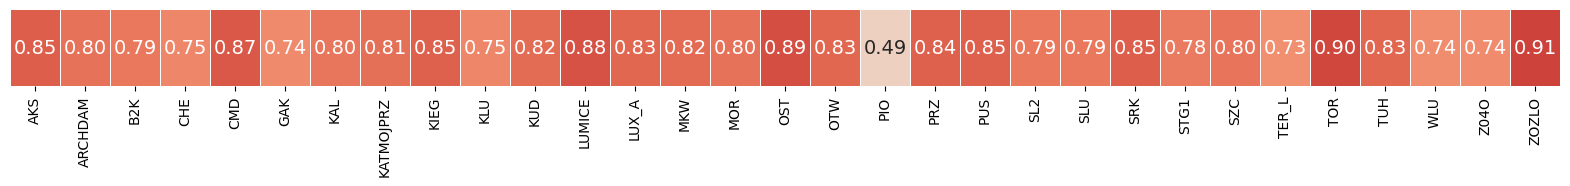

In [106]:
results_df_AUC = results_df.loc[:, ['AUC']].transpose()
plt.figure(figsize=(20, 1))
ax = sns.heatmap(results_df_AUC, cmap="coolwarm", center=0.4, vmin=0, vmax=1, 
            annot=True, fmt=".2f", linewidths=0.5, cbar=False, annot_kws={"size": 14})
ax.set_yticklabels([""])
ax.set_yticks([])
ax.set_ylabel("")
#ax.set_title("Average MCC for Each Class (5-Fold CV)", fontsize=15)
plt.savefig('results/pathology_classification/loo_results.png', dpi=300, bbox_inches='tight')
plt.show()